# Import Modules

In [265]:
import os, sys
import pandas as pd
import numpy as np
import datetime as dt
from pprint import pprint
import csv
import itertools as it
from prettytable import PrettyTable
import matplotlib.pylab as plt
import seaborn as sns
import portion as P
from collections import namedtuple

pdir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # for jupyter-notebook
sys.path.insert(1, pdir)
from myutils import *

%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')

pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

datadir = "/Users/jackbedford/Desktop/MOXA/Code/data"
exp = "_Bandlock_Udp_B1_B3_B7_B8_RM500Q"
devices = [
    'qc00',
    'qc01',
    'qc02',
    'qc03',
]
schemes = [
    'B1',
    'B3',
    'B7',
    'B8',
]
dates = {
    "2023-03-15": [*['#{:02d}'.format(i+1) for i in range(1, 4)], '#06'],
    "2023-03-16": ['#{:02d}'.format(i+1) for i in range(16)],
}

In [16]:
def set_data(df):
    df['seq'] = df['seq'].astype('Int32')
    df['rpkg'] = df['rpkg'].astype('Int8')
    df['frame_id'] = df['frame_id'].astype('Int32')
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['xmit_time'] = pd.to_datetime(df['xmit_time'])
    df['arr_time'] = pd.to_datetime(df['arr_time'])
    df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
    df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
    df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
    df['lost'] = df['lost'].astype('boolean')
    df['excl'] = df['excl'].astype('boolean')
    df['latency'] = df['latency'].astype('float32')
    return df

# Test

In [229]:
df_ho = pd.read_csv("/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/_Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#01/data/diag_log_qc03_2023-04-01_15-21-12_rrc.csv")
df_dl = pd.read_csv("/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/_Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#01/data/udp_dnlk_loss_latency.csv")
df_ul = pd.read_csv("/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/_Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#01/data/udp_uplk_loss_latency.csv")

df_ho, _, _ = mi_parse_ho(df_ho, tz=8)
df_ho['ho_type0'] = df_ho['ho_type'].astype('string')
df_ho.loc[df_ho['cause'].notna(), 'ho_type0'] = df_ho['ho_type'].astype('string') + '_' + df_ho['cause'].astype('string')
df_ho['ho_type0'] = df_ho['ho_type0'].astype('category')
df_dl = set_data(df_dl)
df_ul = set_data(df_ul)

,start,end,ho_type,intr,sPCI,sFreq,tPCI,tFreq,snrPCI,tnrPCI,cause,others,st_scel,ePCI,ECI,eNB,BID,DL_Freq,DL_BW,UL_Freq,UL_BW,ePCI1,ECI1,eNB1,BID1,DL_Freq1,DL_BW1,UL_Freq1,UL_BW1,nrPCI,nrFreq,nrPCI1,nrFreq1,Timestamp,type_id,ho_type0
0,2023-04-01 15:22:22.239022,2023-04-01 15:22:22.315842,MCG_Failure,0.076820,130,1750,22,<NA>,3,<NA>,otherFailure (2),<NA>,0,130,54303511,212123,3,1750,20 MHz,19750,20 MHz,130,54303511,212123,3,1750,20 MHz,19750,20 MHz,3,631000,<NA>,<NA>,2023-04-01 15:22:22.239022,RRC_OTA_Handover_Parsing,MCG_Failure_otherFailure (2)
1,2023-04-01 15:22:29.147945,2023-04-01 15:22:29.222987,MCG_Failure,0.075042,11,3650,130,<NA>,11,<NA>,otherFailure (2),<NA>,0,11,54547467,213076,8,3650,10 MHz,21650,10 MHz,11,54547467,213076,8,3650,10 MHz,21650,10 MHz,11,631000,<NA>,<NA>,2023-04-01 15:22:29.147945,RRC_OTA_Handover_Parsing,MCG_Failure_otherFailure (2)


2023-04-01 15:22:22.239022
2023-04-01 15:22:22.315842
2023-04-01 15:22:22.277432


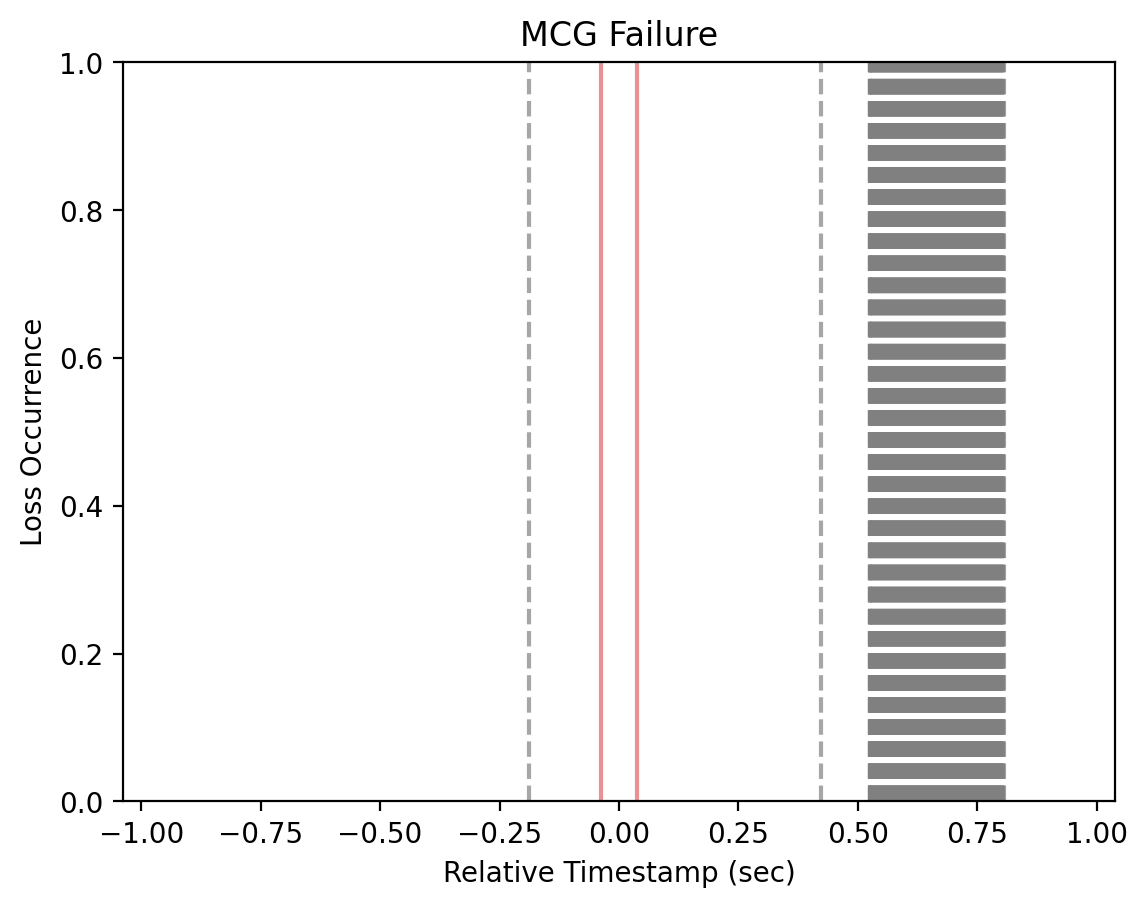

In [261]:
df = df_ho.query('ho_type == "MCG_Failure"').copy().reset_index(drop=True)
display(df)

idx = 0
start = df.at[idx, 'start']
end = df.at[idx, 'end']
midpoint = start + (end - start) / 2
print(start, end, midpoint, sep='\n')

sec = 1
intv = P.closed(start-pd.Timedelta(seconds=sec), end+pd.Timedelta(seconds=sec))

# df_ul.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper')
# df_ul.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper & lost == True')
# df_dl.query('arr_time >= @intv.lower & arr_time <= @intv.upper')
# df_dl.query('arr_time >= @intv.lower & arr_time <= @intv.upper & lost == True')

df_plot = df_dl.query('arr_time >= @intv.lower & arr_time <= @intv.upper & lost == True').copy().reset_index(drop=True)
df_plot['rel_time'] = (df_plot['arr_time'] - midpoint).dt.total_seconds()
df_plot

fig, ax = plt.subplots()
ax.set_xlim([(intv.lower-midpoint).total_seconds(), (intv.upper-midpoint).total_seconds()])
ax.set_title('MCG Failure')
for ts in df_plot['rel_time']:
    ax.axvline(ts, linestyle='--', color='gray', alpha=0.7)
ax.axvline((start-midpoint).total_seconds(), color='tab:red', alpha=0.5)
ax.axvline((end-midpoint).total_seconds(), color='tab:red', alpha=0.5)
ax.set_xlabel('Relative Timestamp (sec)')
ax.set_ylabel('Loss Occurrence')

plt.show()

,start,end,ho_type,intr,sPCI,sFreq,tPCI,tFreq,snrPCI,tnrPCI,cause,others,st_scel,ePCI,ECI,eNB,BID,DL_Freq,DL_BW,UL_Freq,UL_BW,ePCI1,ECI1,eNB1,BID1,DL_Freq1,DL_BW1,UL_Freq1,UL_BW1,nrPCI,nrFreq,nrPCI1,nrFreq1,Timestamp,type_id,ho_type0
0,2023-04-01 15:22:22.786446,2023-04-01 15:22:22.824023,SN_Setup,0.037577,130,1750,<NA>,<NA>,<NA>,11,NaN,<NA>,0,130,54303511,212123,3,1750,20 MHz,19750,20 MHz,130,54303511,212123,3,1750,20 MHz,19750,20 MHz,130,631000,11,631000,2023-04-01 15:22:22.786446,RRC_OTA_Handover_Parsing,SN_Setup
1,2023-04-01 15:22:29.544480,2023-04-01 15:22:29.583170,SN_Setup,0.038690,11,3650,<NA>,<NA>,<NA>,11,NaN,Set up 1 SCell.,1,11,54547467,213076,8,3650,10 MHz,21650,10 MHz,11,54547467,213076,8,3650,10 MHz,21650,10 MHz,11,631000,11,631000,2023-04-01 15:22:29.544480,RRC_OTA_Handover_Parsing,SN_Setup


2023-04-01 15:22:22.786446
2023-04-01 15:22:22.824023
2023-04-01 15:22:22.805234500


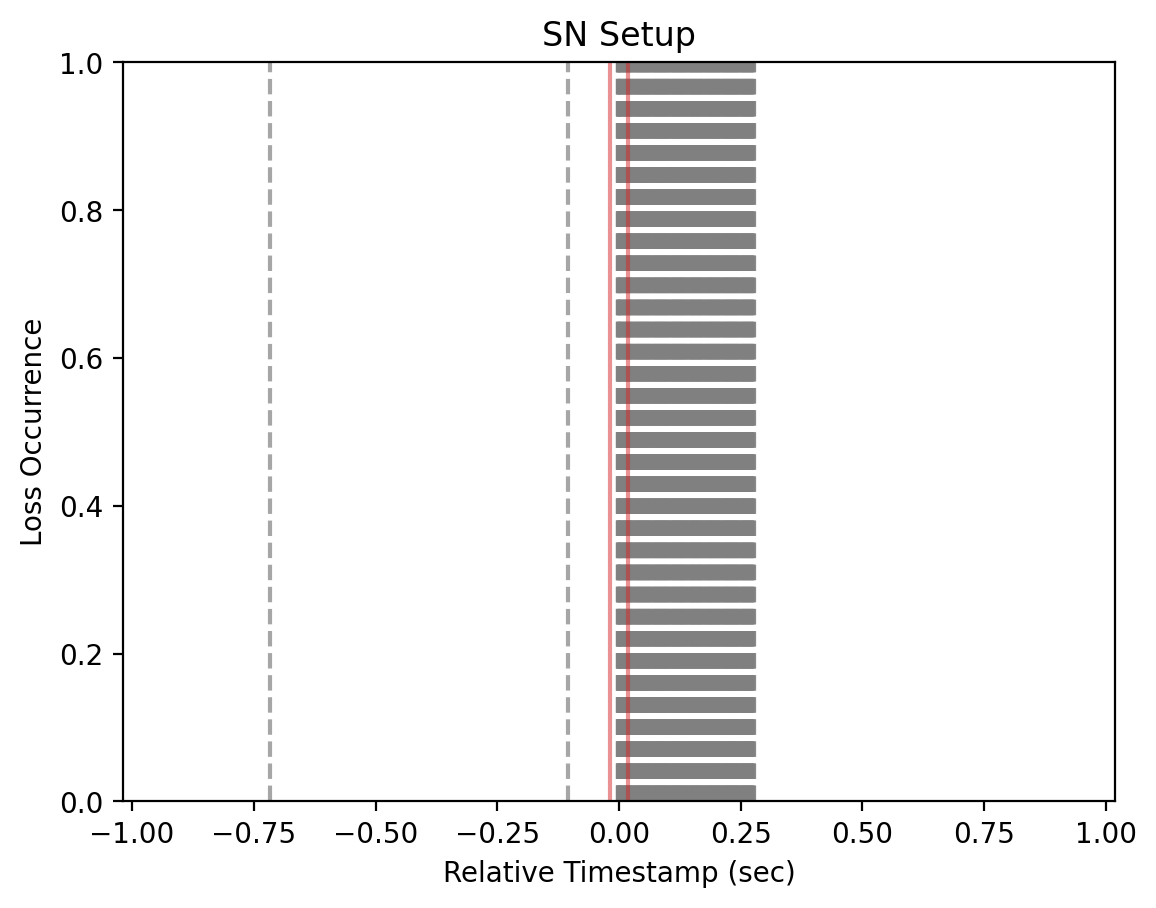

In [262]:
df = df_ho.query('ho_type == "SN_Setup"').copy().reset_index(drop=True)
display(df)

idx = 0
start = df.at[idx, 'start']
end = df.at[idx, 'end']
midpoint = start + (end - start) / 2
print(start, end, midpoint, sep='\n')

sec = 1
intv = P.closed(start-pd.Timedelta(seconds=sec), end+pd.Timedelta(seconds=sec))

# df_ul.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper')
# df_ul.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper & lost == True')
# df_dl.query('arr_time >= @intv.lower & arr_time <= @intv.upper')
# df_dl.query('arr_time >= @intv.lower & arr_time <= @intv.upper & lost == True')

df_plot = df_dl.query('arr_time >= @intv.lower & arr_time <= @intv.upper & lost == True').copy().reset_index(drop=True)
df_plot['rel_time'] = (df_plot['arr_time'] - midpoint).dt.total_seconds()
df_plot

fig, ax = plt.subplots()
ax.set_xlim([(intv.lower-midpoint).total_seconds(), (intv.upper-midpoint).total_seconds()])
ax.set_title('SN Setup')
for ts in df_plot['rel_time']:
    ax.axvline(ts, linestyle='--', color='gray', alpha=0.7)
ax.axvline((start-midpoint).total_seconds(), color='tab:red', alpha=0.5)
ax.axvline((end-midpoint).total_seconds(), color='tab:red', alpha=0.5)
ax.set_xlabel('Relative Timestamp (sec)')
ax.set_ylabel('Loss Occurrence')

plt.show()

In [235]:
def setup_profile(df, start, end, mode='ul', sec=1):
    if pd.notna(end):
        midpoint = start + (end - start) / 2
        intv = P.closed(start-pd.Timedelta(seconds=sec), end+pd.Timedelta(seconds=sec))
    else:
        midpoint = start
        intv = P.closed(start-pd.Timedelta(seconds=sec), start+pd.Timedelta(seconds=sec))
    
    # print(start, end, midpoint, sep='\n')
    # print(start, end, midpoint)
    
    if mode == 'ul':
        df_plot = df.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['xmit_time'] - midpoint).dt.total_seconds()
    else: # 'dl'
        df_plot = df.query('arr_time >= @intv.lower & arr_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['arr_time'] - midpoint).dt.total_seconds()
    df_plot['cat_id'] = ((df_plot['rel_time'] + 0.005) // 0.01) * 0.01
    # display(df_plot)

    ts_group = df_plot.groupby(['cat_id'])
    table = ts_group['lost'].agg(['count','sum','mean']).copy().reset_index()
    table = table.rename(columns={'count':'tx_count', 'sum':'lost', 'mean':'PLR'})
    table['PLR'] = table['PLR'] * 100
    # display(table)
    return table, intv

def merge_profile(tables, intrs):
    intr = np.mean(intrs)
    table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
    table['cat_id'] = table['cat_id'].astype('float32')
    table['tx_count'] = table['tx_count'].astype('Int32')
    table['lost'] = table['lost'].astype('Int32')
    table['PLR'] = table['PLR'].astype('float32')
    for i in range(len(tables)):
        _table = tables[i].copy()
        table = table.merge(_table, on=['cat_id'], how='outer').fillna(0)
        table['tx_count'] = table['tx_count_x'] + table['tx_count_y']
        table['lost'] = table['lost_x'] + table['lost_y']
        table['PLR'] = 0
        table = table[['cat_id','tx_count','lost','PLR']]
    table['PLR'] = table['lost'] / (table['tx_count'] + 1e-9) * 100
    table = table[['cat_id','tx_count','lost','PLR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    return table, intr

def plot_profile(table, intr=0, title='', mode='lost'):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlim(table.iat[0, table.columns.get_loc('cat_id')], table.iat[-1, table.columns.get_loc('cat_id')])
    # ax.set_xlim([(intv.lower-midpoint).total_seconds(), (intv.upper-midpoint).total_seconds()])
    if mode == 'lost':
        ax.bar(table['cat_id'], table['lost'], width=0.5)
        ax.set_ylabel('Lost Number')
    if mode == 'plr':
        ax.bar(table['cat_id'], table['PLR'], width=0.5)
        ax.set_ylabel('Packet Loss Rate (%)')
    intr /= 2
    # ax.axvline((start-midpoint).total_seconds(), color='tab:red', alpha=0.5)
    # ax.axvline((end-midpoint).total_seconds(), color='tab:red', alpha=0.5)
    ax.axvline(-intr, color='tab:red', alpha=0.5)
    ax.axvline(intr, color='tab:red', alpha=0.5)
    ax.set_xlabel('Relative Timestamp (sec)')
    plt.gcf().autofmt_xdate()
    plt.show()

,start,end,ho_type,intr,sPCI,sFreq,tPCI,tFreq,snrPCI,tnrPCI,cause,others,st_scel,ePCI,ECI,eNB,BID,DL_Freq,DL_BW,UL_Freq,UL_BW,ePCI1,ECI1,eNB1,BID1,DL_Freq1,DL_BW1,UL_Freq1,UL_BW1,nrPCI,nrFreq,nrPCI1,nrFreq1,Timestamp,type_id,ho_type0
0,2023-04-01 15:22:22.239022,2023-04-01 15:22:22.315842,MCG_Failure,0.076820,130,1750,22,<NA>,3,<NA>,otherFailure (2),<NA>,0,130,54303511,212123,3,1750,20 MHz,19750,20 MHz,130,54303511,212123,3,1750,20 MHz,19750,20 MHz,3,631000,<NA>,<NA>,2023-04-01 15:22:22.239022,RRC_OTA_Handover_Parsing,MCG_Failure_otherFailure (2)
1,2023-04-01 15:22:29.147945,2023-04-01 15:22:29.222987,MCG_Failure,0.075042,11,3650,130,<NA>,11,<NA>,otherFailure (2),<NA>,0,11,54547467,213076,8,3650,10 MHz,21650,10 MHz,11,54547467,213076,8,3650,10 MHz,21650,10 MHz,11,631000,<NA>,<NA>,2023-04-01 15:22:29.147945,RRC_OTA_Handover_Parsing,MCG_Failure_otherFailure (2)


0.075931


,cat_id,tx_count,lost,PLR
0,-1.04,2.0,0,0.0
1,-1.03,10.0,0,0.0
2,-1.02,10.0,0,0.0
3,-1.01,6.0,0,0.0
4,-1.00,11.0,0,0.0
...,...,...,...,...
204,1.00,8.0,0,0.0
205,1.01,10.0,0,0.0
206,1.02,6.0,0,0.0
207,1.03,3.0,0,0.0


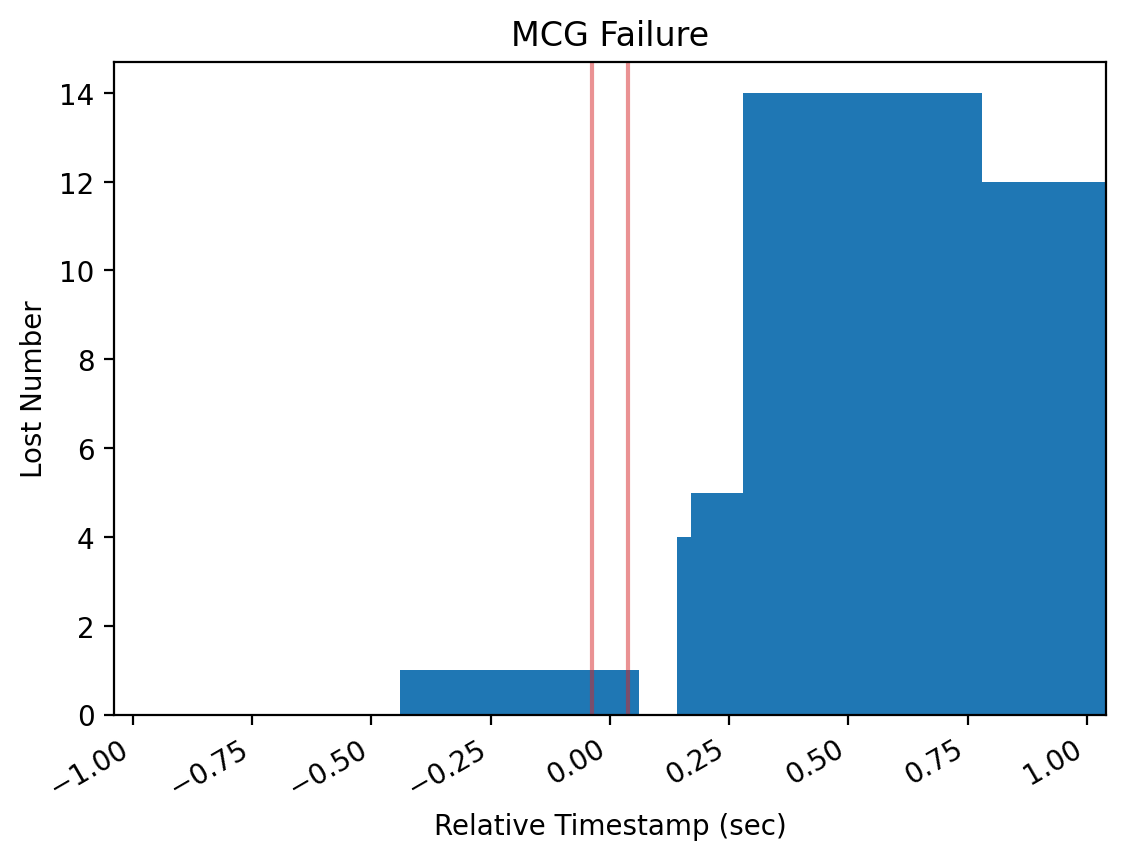

In [236]:
df = df_ho.query('ho_type == "MCG_Failure"').copy().reset_index(drop=True)
display(df)
tables = []
intrs = []
for i, row in df.iterrows():
    # display(df)
    start, end, intr = df.at[i, 'start'], df.at[i, 'end'], df.at[i, 'intr']
    table, intv = setup_profile(df_dl, start, end, mode='dl', sec=1)
    tables.append(table)
    intrs.append(intr)
    # plot_profile(table, intr=intr, title='MCG Failure')
table, intr = merge_profile(tables, intrs)
print(intr)
display(table)
plot_profile(table, intr=intr, title='MCG Failure')

# GO!

In [272]:
DF = namedtuple('DF', 'filename, df', defaults=tuple([None]*2))
def set_data(df):
    df['seq'] = df['seq'].astype('Int32')
    df['rpkg'] = df['rpkg'].astype('Int8')
    df['frame_id'] = df['frame_id'].astype('Int32')
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['xmit_time'] = pd.to_datetime(df['xmit_time'])
    df['arr_time'] = pd.to_datetime(df['arr_time'])
    df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
    df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
    df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
    df['lost'] = df['lost'].astype('boolean')
    df['excl'] = df['excl'].astype('boolean')
    df['latency'] = df['latency'].astype('float32')
    return df

In [307]:
def setup_profile(df, start, end, mode='ul', sec=1):
    if pd.notna(end):
        midpoint = start + (end - start) / 2
        intv = P.closed(start-pd.Timedelta(seconds=sec), end+pd.Timedelta(seconds=sec))
    else:
        midpoint = start
        intv = P.closed(start-pd.Timedelta(seconds=sec), start+pd.Timedelta(seconds=sec))
    
    # print(start, end, midpoint, sep='\n')
    # print(start, end, midpoint)
    
    if mode == 'ul':
        df_plot = df.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['xmit_time'] - midpoint).dt.total_seconds()
    else: # 'dl'
        df_plot = df.query('arr_time >= @intv.lower & arr_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['arr_time'] - midpoint).dt.total_seconds()
    df_plot['cat_id'] = ((df_plot['rel_time'] + 0.005) // 0.01) * 0.01
    # display(df_plot)

    ts_group = df_plot.groupby(['cat_id'])
    table = ts_group['lost'].agg(['count','sum','mean']).copy().reset_index()
    table = table.rename(columns={'count':'tx_count', 'sum':'lost', 'mean':'PLR'})
    table['PLR'] = table['PLR'] * 100
    # display(table)
    return table, intv

def merge_profile(tables, intrs):
    intr = np.mean(intrs)
    table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
    table['cat_id'] = table['cat_id'].astype('float32')
    table['tx_count'] = table['tx_count'].astype('Int32')
    table['lost'] = table['lost'].astype('Int32')
    table['PLR'] = table['PLR'].astype('float32')
    for i in range(len(tables)):
        _table = tables[i].copy()
        table = table.merge(_table, on=['cat_id'], how='outer').fillna(0)
        table['tx_count'] = table['tx_count_x'] + table['tx_count_y']
        table['lost'] = table['lost_x'] + table['lost_y']
        table['PLR'] = 0
        table = table[['cat_id','tx_count','lost','PLR']]
    table['PLR'] = table['lost'] / (table['tx_count'] + 1e-9) * 100
    table = table[['cat_id','tx_count','lost','PLR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    return table, intr

def plot_profile(table, intr=0, title='', mode='lost'):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlim(table.iat[0, table.columns.get_loc('cat_id')], table.iat[-1, table.columns.get_loc('cat_id')])
    # ax.set_xlim([(intv.lower-midpoint).total_seconds(), (intv.upper-midpoint).total_seconds()])
    if mode == 'lost':
        ax.bar(table['cat_id'], table['lost'], width=0.5)
        ax.set_ylabel('Lost Number')
    if mode == 'plr':
        ax.bar(table['cat_id'], table['PLR'], width=0.5)
        ax.set_ylabel('Packet Loss Rate (%)')
        ax.set_ylim(top=105)
    intr /= 2
    # ax.axvline((start-midpoint).total_seconds(), color='tab:red', alpha=0.5)
    # ax.axvline((end-midpoint).total_seconds(), color='tab:red', alpha=0.5)
    ax.axvline(-intr, color='tab:red', alpha=0.5)
    ax.axvline(intr, color='tab:red', alpha=0.5)
    ax.set_xlabel('Relative Timestamp (sec)')
    plt.gcf().autofmt_xdate()
    plt.show()

LTE_HO
Avg Duration: 0.0261545 seconds


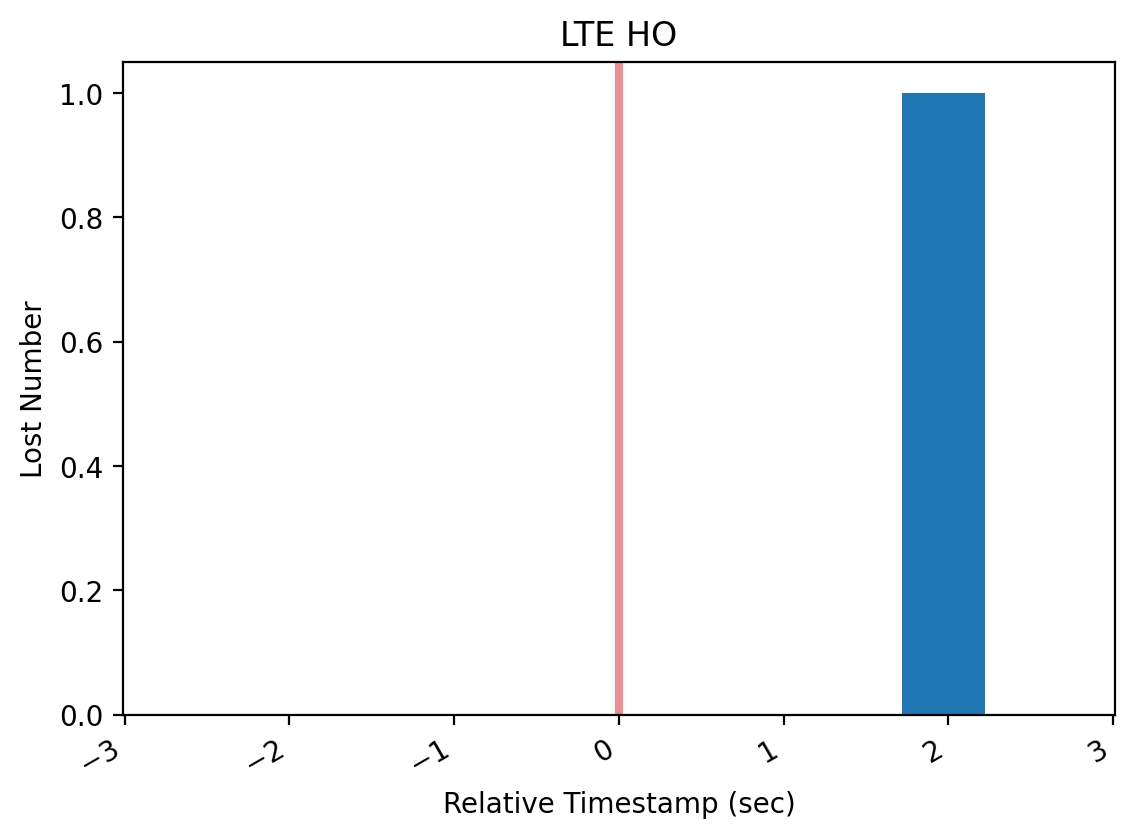

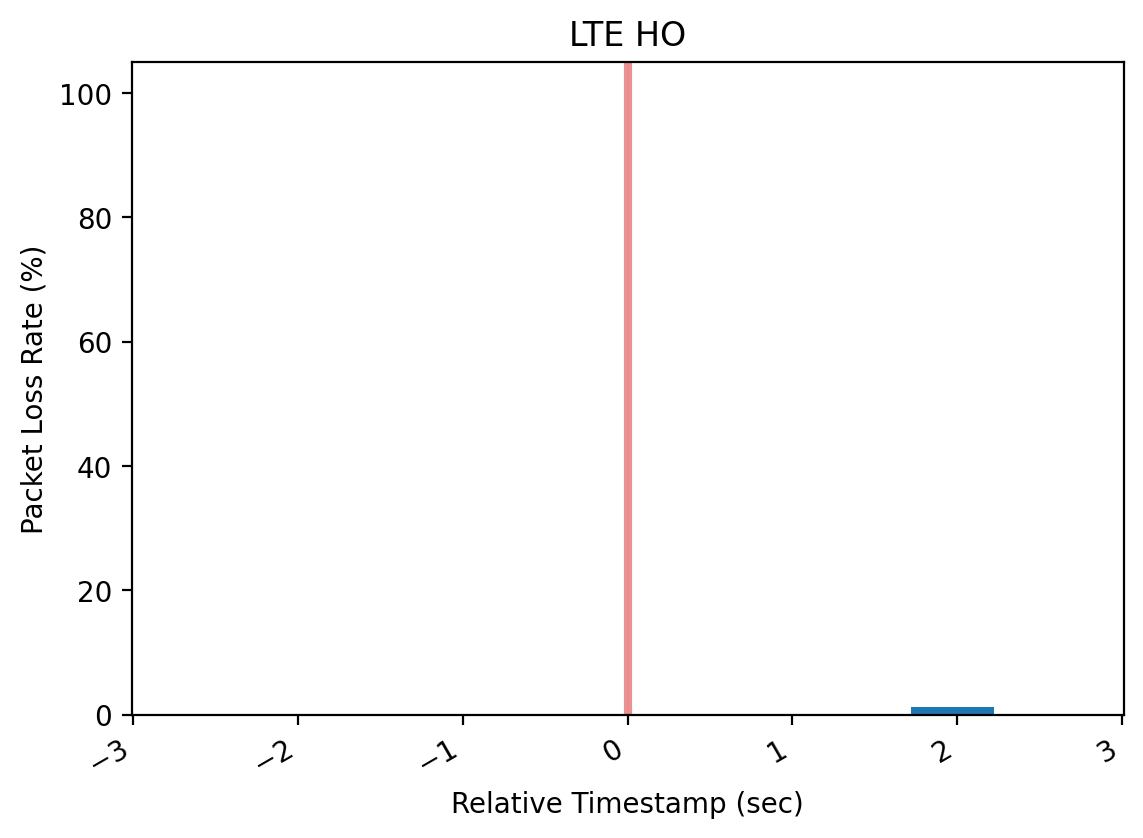

HO Count: 2
MN_HO
Avg Duration: 0.0164715 seconds


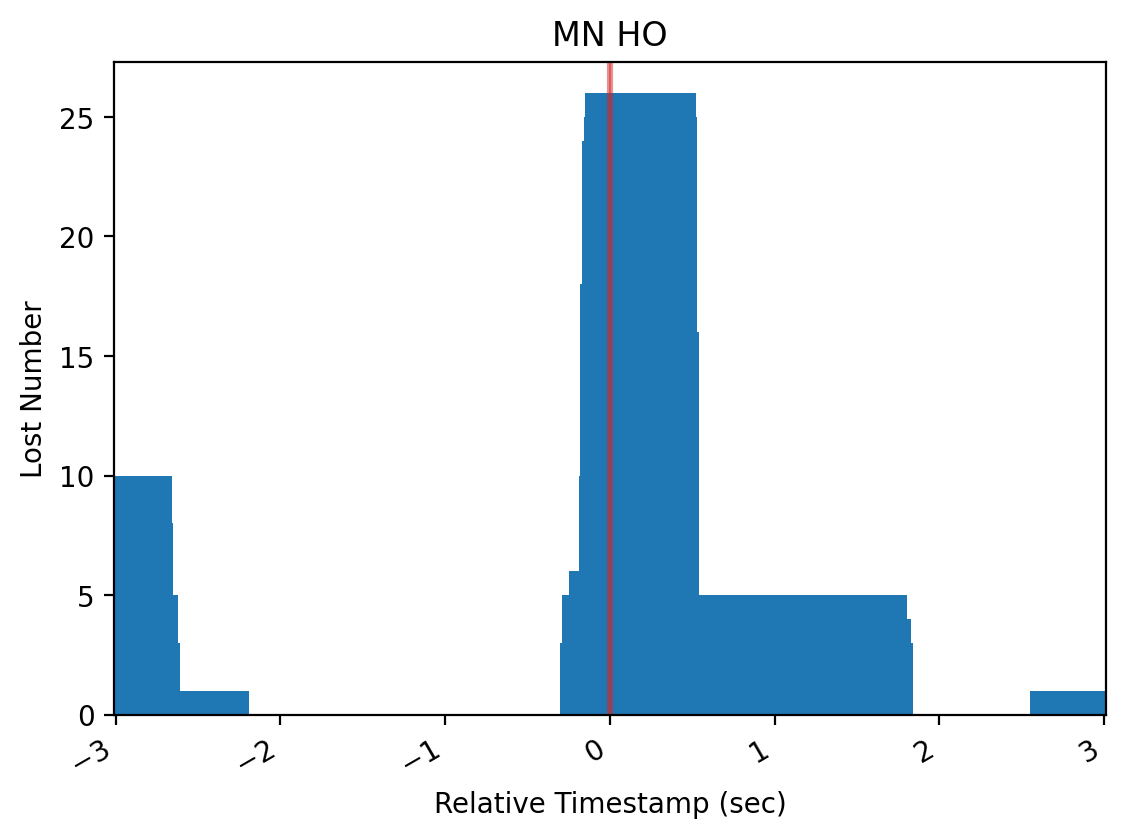

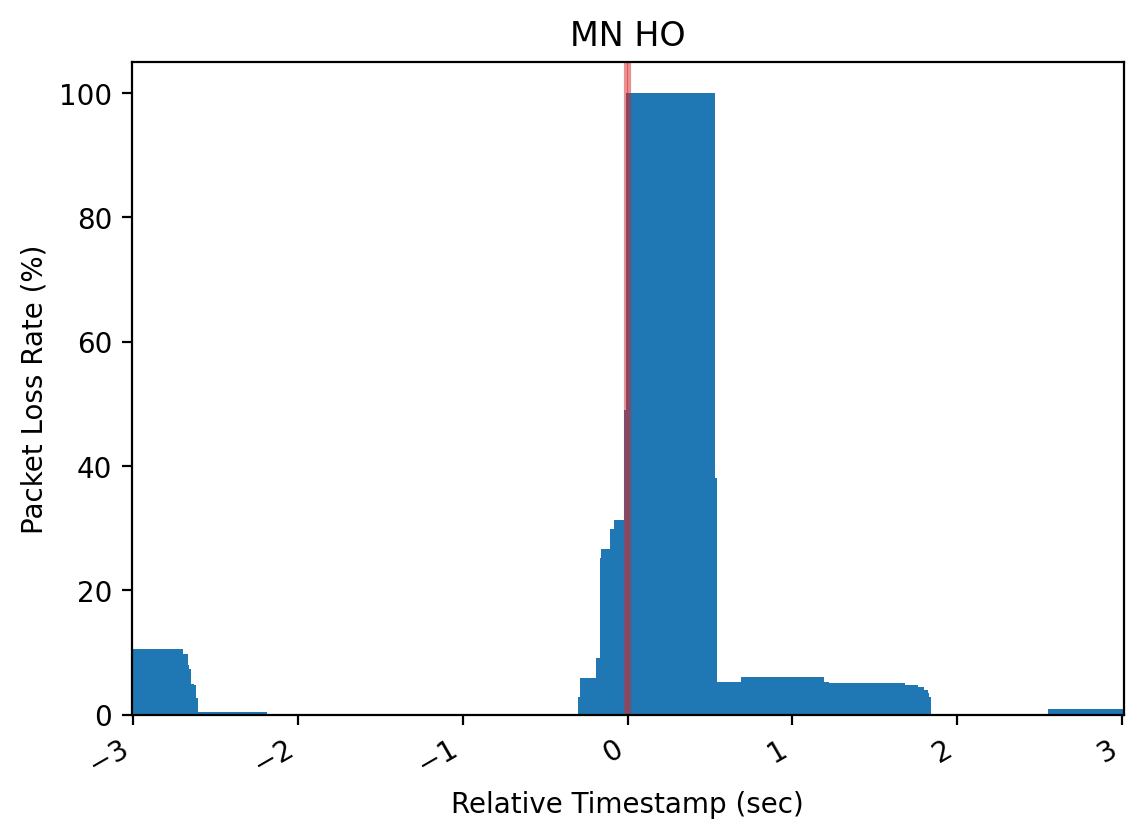

HO Count: 24
SN_HO
Avg Duration: 0.014224353 seconds


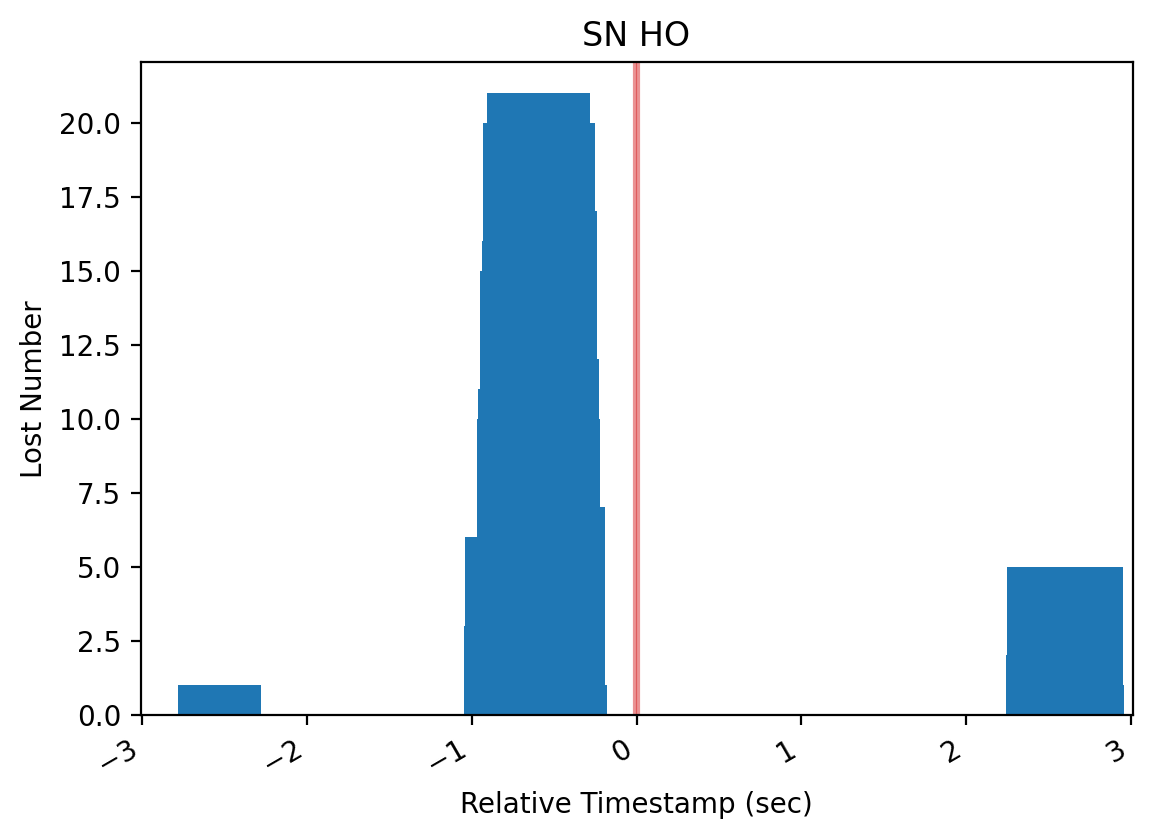

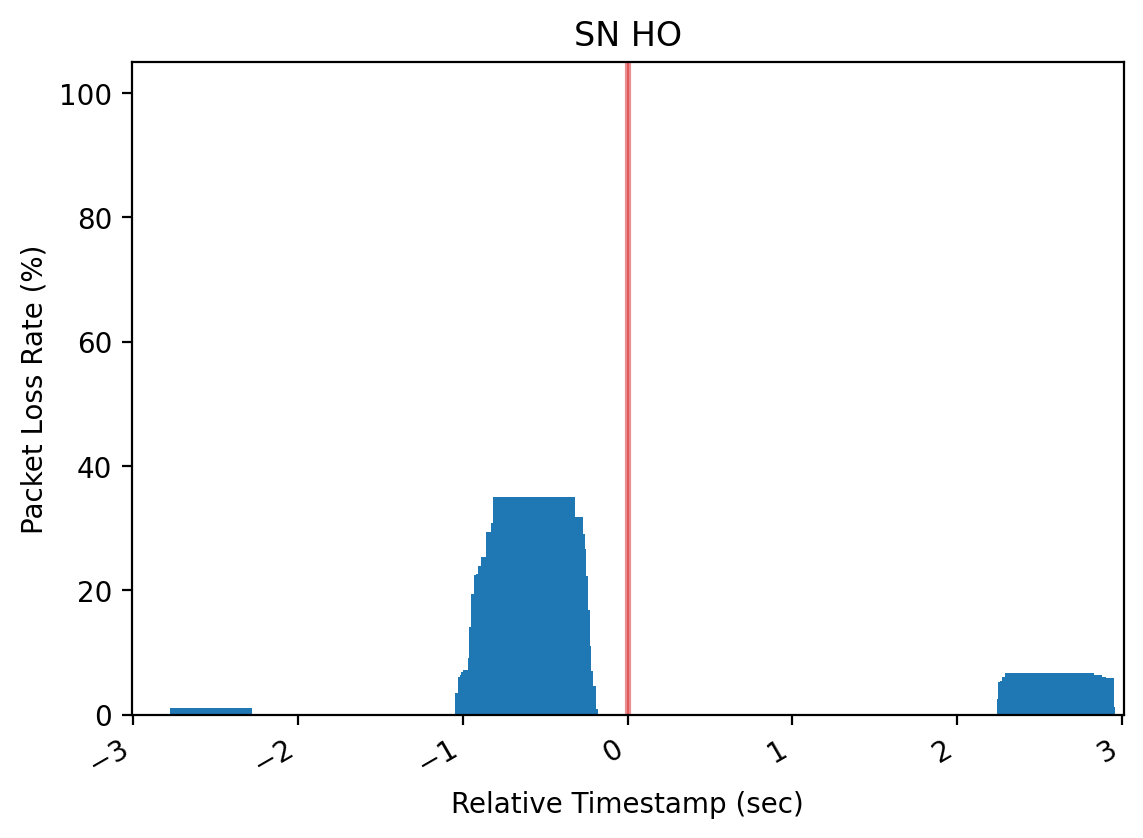

HO Count: 17
MNSN_HO
HO Count: 0
SN_Rel
HO Count: 0
SN_Setup
Avg Duration: 0.0086392 seconds


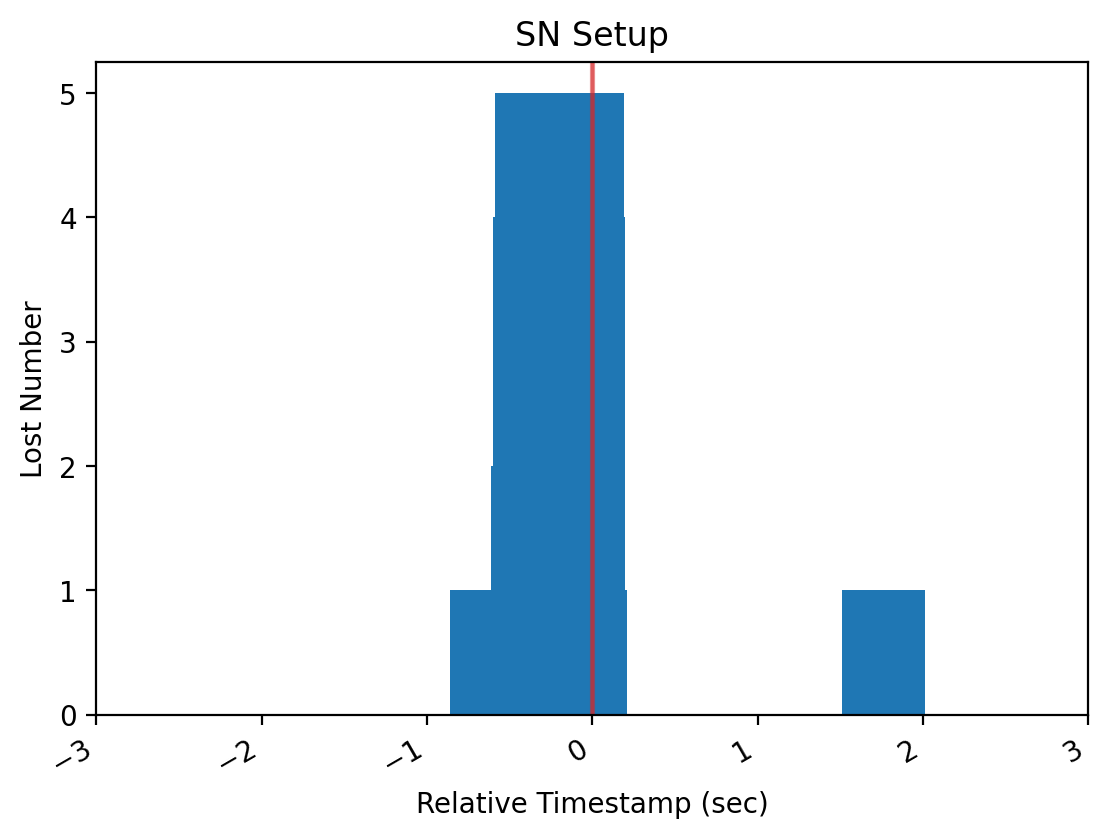

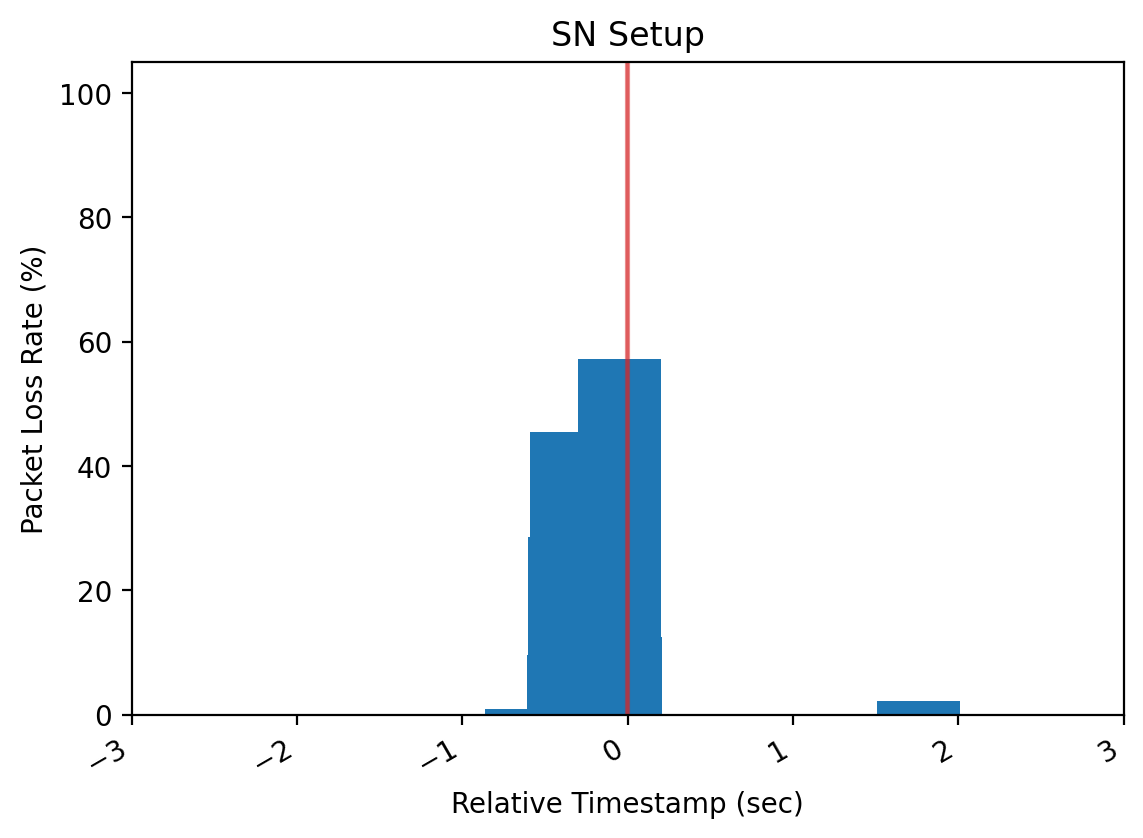

HO Count: 5
SN_Rel_MN_HO
HO Count: 0
SN_Setup_MN_HO
HO Count: 0
SCG_Failure_t310-Expiry (0)
HO Count: 0
SCG_Failure_randomAccessProblem (1)
HO Count: 0
SCG_Failure_rlc-MaxNumRetx (2)
HO Count: 0
SCG_Failure_synchReconfigFailureSCG (3)
HO Count: 0
SCG_Failure_scg-ReconfigFailure (4)
HO Count: 0
SCG_Failure_srb3-IntegrityFailure (5)
HO Count: 0
SCG_Failure_other-r16 (6)
HO Count: 0
MCG_Failure_reconfigurationFailure (0)
HO Count: 0
MCG_Failure_handoverFailure (1)
HO Count: 0
MCG_Failure_otherFailure (2)
Avg Duration: 0.067012 seconds


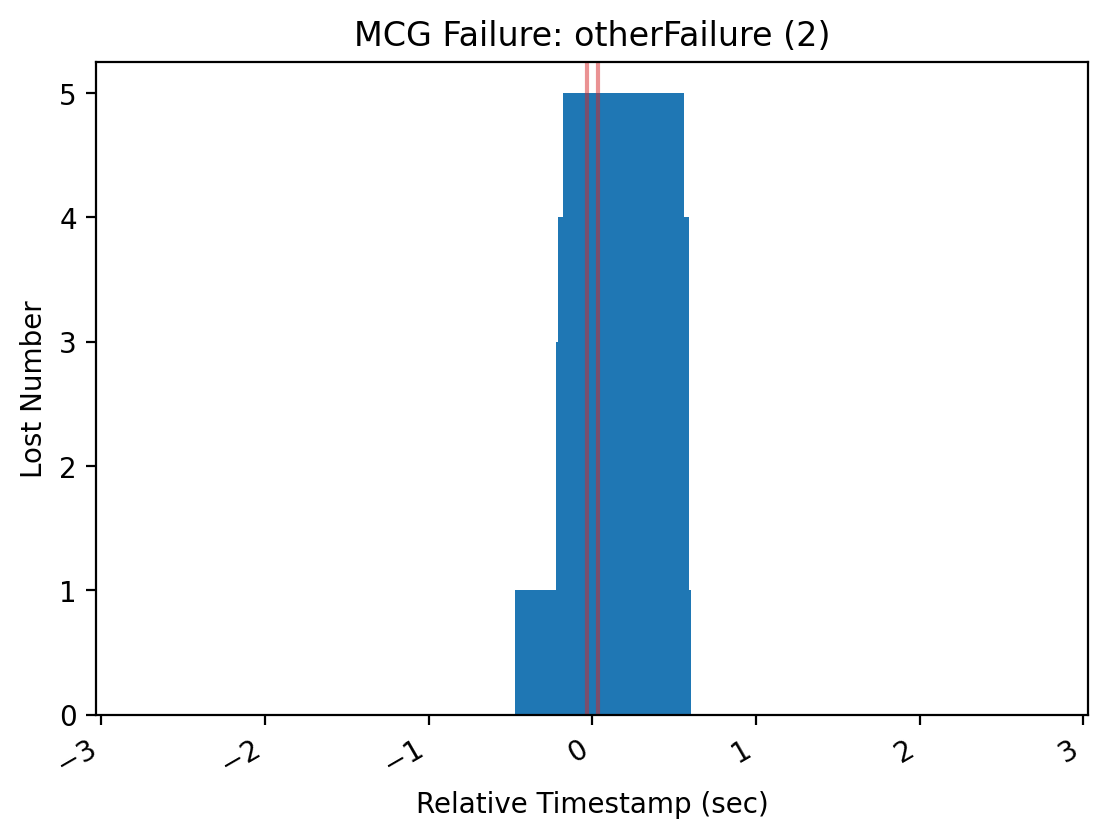

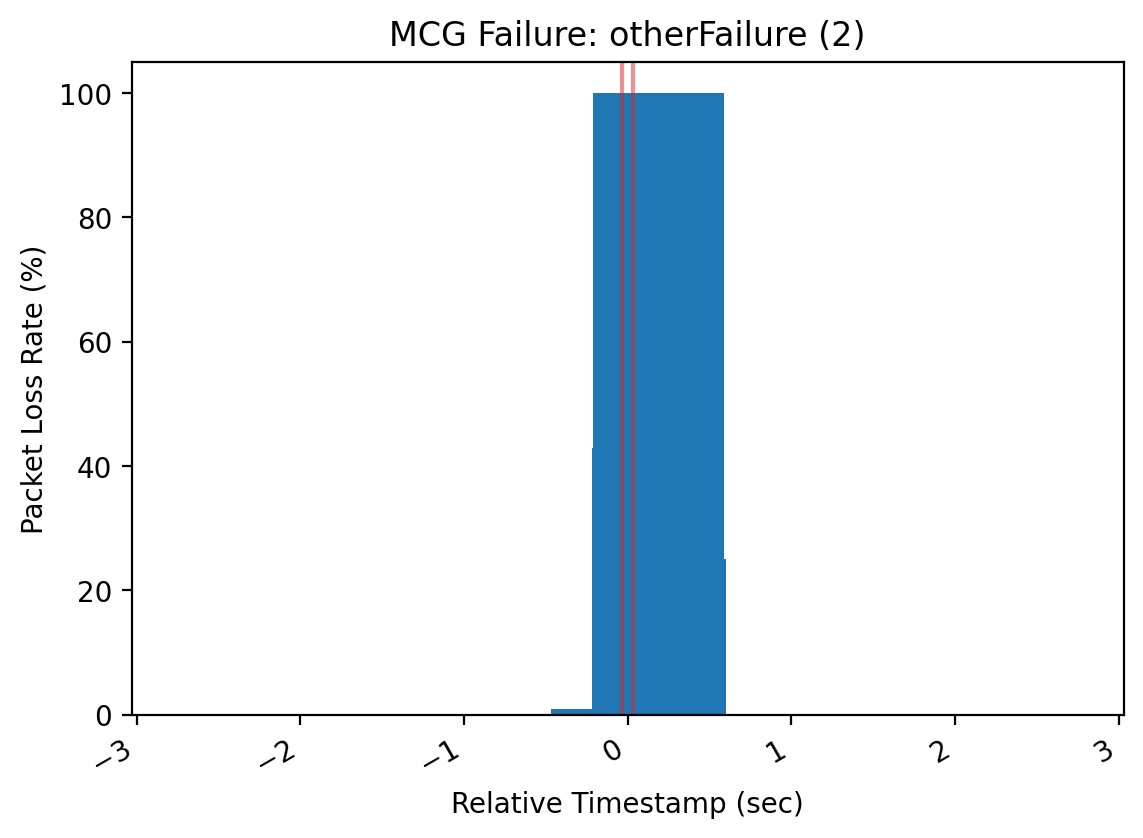

HO Count: 2
NAS_Recovery_reconfigurationFailure (0)
HO Count: 0
NAS_Recovery_handoverFailure (1)
HO Count: 0
NAS_Recovery_otherFailure (2)
HO Count: 0


In [308]:
sorter = ['LTE_HO','MN_HO','SN_HO','MNSN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO','SN_Setup_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

for tag in sorter:
    print('===================================')
    print(tag)
    df = df_ho.query('ho_type0 == @tag').copy().reset_index(drop=True)
    if not df.empty:
        cname = ' '.join(df.at[0, 'ho_type'].split('_')) + ': ' + df.at[0, 'cause'] if pd.notna(df.at[0, 'cause']) else ' '.join(df.at[0, 'ho_type'].split('_'))
        tables = []
        intrs = []
        for i, row in df.iterrows():
            start, end = df.at[i, 'start'], df.at[i, 'end']
            intr = df.at[i, 'intr'] if pd.notna(df.at[i, 'intr']) else 0
            table, intv = setup_profile(df_dl, start, end, mode='dl', sec=3)
            # print(intr)
            # display(table)
            tables.append(table)
            intrs.append(intr)
        table, intr = merge_profile(tables, intrs)
        print('Avg Duration:', intr, 'seconds')
        # display(table)
        plot_profile(table, intr=intr, title=cname, mode='lost')
        plot_profile(table, intr=intr, title=cname, mode='plr')
    else:
        table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
        table['cat_id'] = table['cat_id'].astype('float32')
        table['tx_count'] = table['tx_count'].astype('Int32')
        table['lost'] = table['lost'].astype('Int32')
        table['PLR'] = table['PLR'].astype('float32')
        intr = 0
    print('HO Count:', len(df))

## Downlink

In [274]:
datadir = "/Users/jackbedford/Desktop/MOXA/Code/data"
exp = "_Bandlock_Udp_B1_B3_B7_B8_RM500Q"
devices = [
    'qc00',
    'qc02',
    'qc03',
]
schemes = [
    'B1',
    'B7',
    'B8',
]
dates = {
    ## Uplink
    # "2023-03-15": [*['#{:02d}'.format(i+1) for i in range(1, 4)], '#06'],
    # "2023-03-16": ['#{:02d}'.format(i+1) for i in range(12)],
    ## Downlink
    "2023-03-16": ['#{:02d}'.format(i+1) for i in range(16)],
}

dfs_dl = []
for date, traces in dates.items():
    for trace in traces:
        for j, (dev, schm) in enumerate(zip(devices, schemes)):
            data = os.path.join(datadir, date, exp, dev, trace, 'data', 'udp_dnlk_loss_latency.csv')
            print(data, os.path.isfile(data))
            df = pd.read_csv(data)
            df = set_data(df)
            dfs_dl.append(DF(data, df.copy()))
print(len(dfs_dl))

dfs_ho = []
for date, traces in dates.items():
    for trace in traces:
        for j, (dev, schm) in enumerate(zip(devices, schemes)):
            path = os.path.join(datadir, date, exp, dev, trace, 'data')
            data = os.path.join(path, [s for s in os.listdir(path) if s.startswith('diag_log_') and s.endswith('_rrc.csv')][0])
            print(data, os.path.isfile(data))
            df = pd.read_csv(data)
            df, _, _ = mi_parse_ho(df, tz=8)
            df['ho_type0'] = df['ho_type'].astype('string')
            df.loc[df['cause'].notna(), 'ho_type0'] = df['ho_type'].astype('string') + '_' + df['cause'].astype('string')
            df['ho_type0'] = df['ho_type0'].astype('category')
            dfs_ho.append(DF(data, df.copy()))
print(len(dfs_ho))

/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#02/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#02/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#03/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM50

In [305]:
sorter = ['LTE_HO','MN_HO','SN_HO','MNSN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO','SN_Setup_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

D = {}
for tag in sorter:
    D[tag] = {'tables': [], 'intrs': [], 'count': []}

N = len(dfs_ho)
for j in range(N):
    df_dl = dfs_dl[j].df.copy()
    df_ho = dfs_ho[j].df.copy()
    for tag in sorter:
        # print('===================================')
        print(tag)
        df = df_ho.query('ho_type0 == @tag').copy().reset_index(drop=True)
        tables = []
        intrs = []
        if not df.empty:
            cname = ' '.join(df.at[0, 'ho_type'].split('_')) + ': ' + df.at[0, 'cause'] if pd.notna(df.at[0, 'cause']) else ' '.join(df.at[0, 'ho_type'].split('_'))
            for i, row in df.iterrows():
                start, end = df.at[i, 'start'], df.at[i, 'end']
                intr = df.at[i, 'intr'] if pd.notna(df.at[i, 'intr']) else 0
                table, intv = setup_profile(df_dl, start, end, mode='dl', sec=5)
                # print(intr)
                # display(table)
                tables.append(table)
                intrs.append(intr)
            table, intr = merge_profile(tables, intrs)
            print('Avg Duration:', intr, 'seconds')
            # display(table)
            # plot_profile(table, intr=intr, title=cname, mode='lost')
            # plot_profile(table, intr=intr, title=cname, mode='plr')
        else:
            table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
            table['cat_id'] = table['cat_id'].astype('float32')
            table['tx_count'] = table['tx_count'].astype('Int32')
            table['lost'] = table['lost'].astype('Int32')
            table['PLR'] = table['PLR'].astype('float32')
            intr = 0
        print('HO Count:', len(df))
        D[tag]['tables'].append(table)
        D[tag]['intrs'] = [*D[tag]['intrs'], *intrs]
        D[tag]['count'].append(len(df))

LTE_HO
Avg Duration: 0.015743159 seconds
HO Count: 25
MN_HO
HO Count: 0
SN_HO
HO Count: 0
MNSN_HO
HO Count: 0
SN_Rel
HO Count: 0
SN_Setup
HO Count: 0
SN_Rel_MN_HO
HO Count: 0
SN_Setup_MN_HO
HO Count: 0
SCG_Failure_t310-Expiry (0)
HO Count: 0
SCG_Failure_randomAccessProblem (1)
HO Count: 0
SCG_Failure_rlc-MaxNumRetx (2)
HO Count: 0
SCG_Failure_synchReconfigFailureSCG (3)
HO Count: 0
SCG_Failure_scg-ReconfigFailure (4)
HO Count: 0
SCG_Failure_srb3-IntegrityFailure (5)
HO Count: 0
SCG_Failure_other-r16 (6)
HO Count: 0
MCG_Failure_reconfigurationFailure (0)
HO Count: 0
MCG_Failure_handoverFailure (1)
HO Count: 0
MCG_Failure_otherFailure (2)
Avg Duration: 0.092678495 seconds
HO Count: 6
NAS_Recovery_reconfigurationFailure (0)
HO Count: 0
NAS_Recovery_handoverFailure (1)
HO Count: 0
NAS_Recovery_otherFailure (2)
HO Count: 0
LTE_HO
Avg Duration: 0.032123 seconds
HO Count: 3
MN_HO
Avg Duration: 0.017912922 seconds
HO Count: 13
SN_HO
Avg Duration: 0.014721191 seconds
HO Count: 21
MNSN_HO
HO Cou

LTE_HO
Avg Duration: 0.019334313 seconds
HO Count: 353


,cat_id,tx_count,lost,PLR
0,-5.02,43.0,0,0.0
1,-5.01,753.0,4,0.531208
2,-5.00,1605.0,5,0.311526
3,-4.99,1604.0,5,0.311721
4,-4.98,1622.0,5,0.308261
...,...,...,...,...
1000,4.98,1595.0,29,1.818182
1001,4.99,1523.0,29,1.904137
1002,5.00,1642.0,28,1.705238
1003,5.01,729.0,20,2.743484


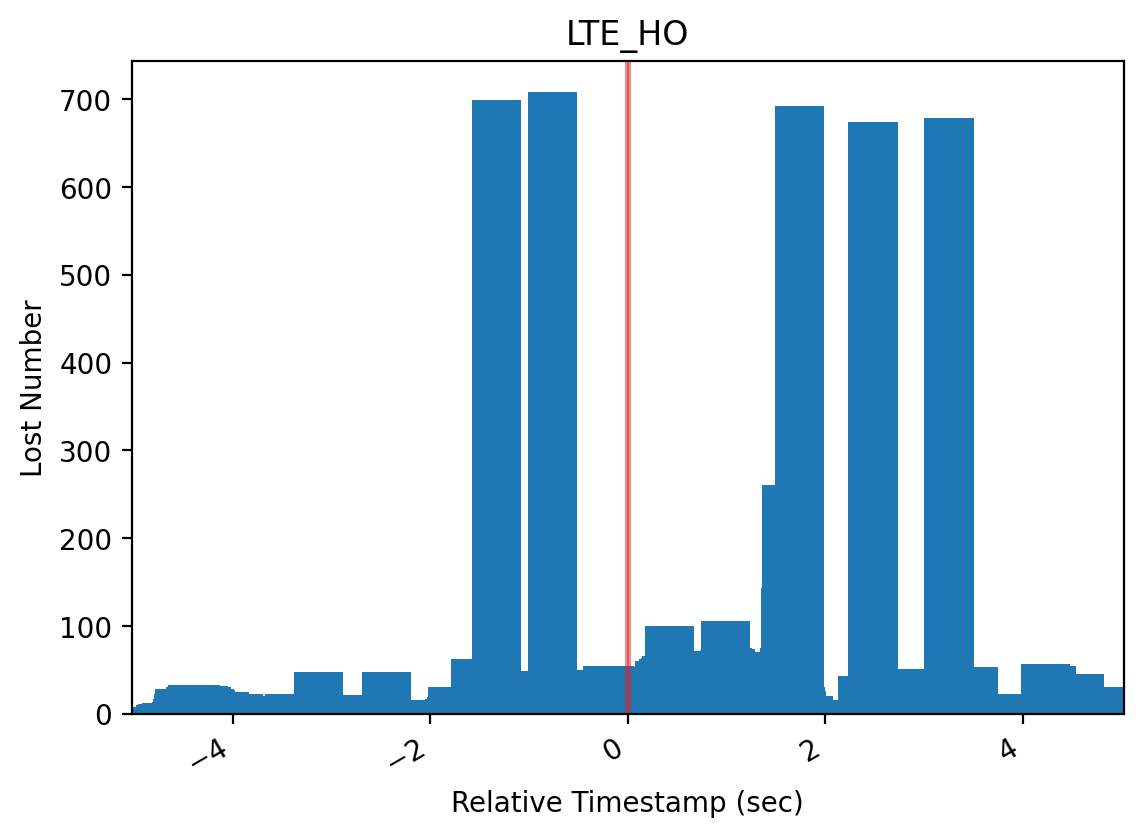

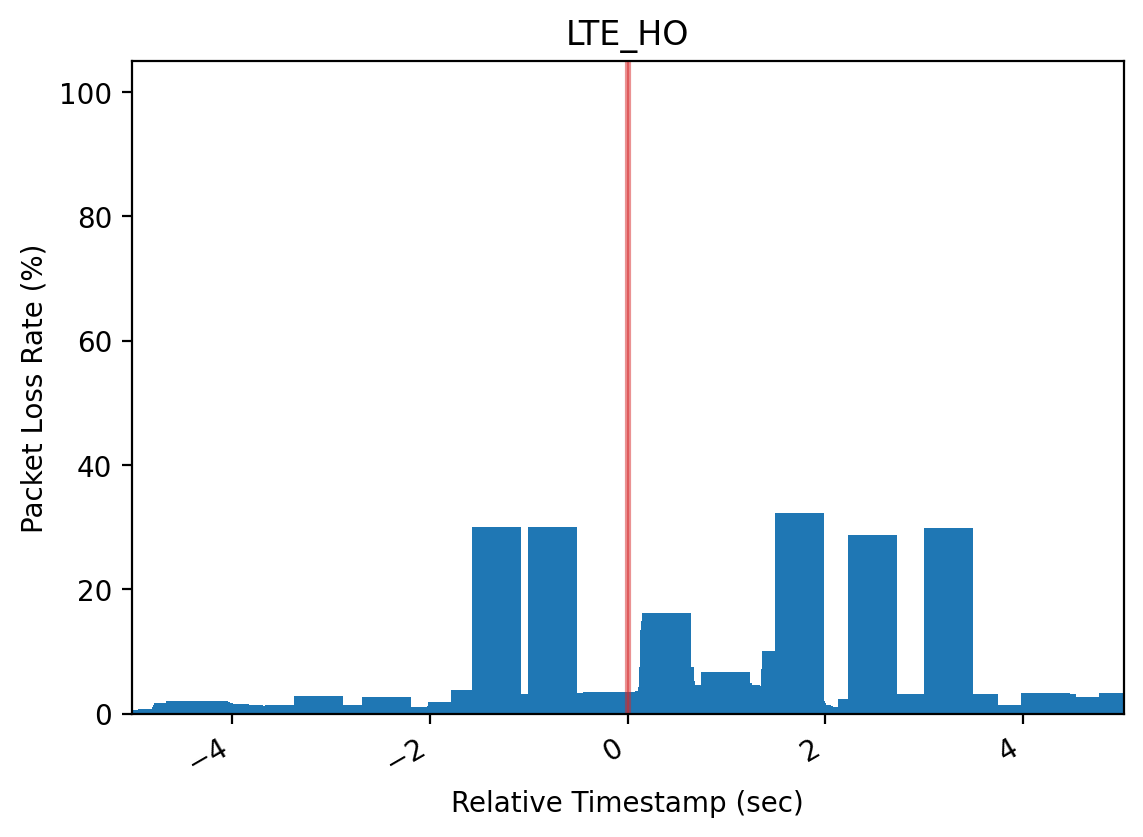

MN_HO
Avg Duration: 0.016966576 seconds
HO Count: 573


,cat_id,tx_count,lost,PLR
0,-5.01,848.0,2,0.235849
1,-5.00,2584.0,5,0.193498
2,-4.99,2592.0,8,0.308642
3,-4.98,2537.0,9,0.35475
4,-4.97,2545.0,9,0.353635
...,...,...,...,...
998,4.97,2500.0,61,2.44
999,4.98,2575.0,60,2.330097
1000,4.99,2522.0,60,2.379064
1001,5.00,2600.0,59,2.269231


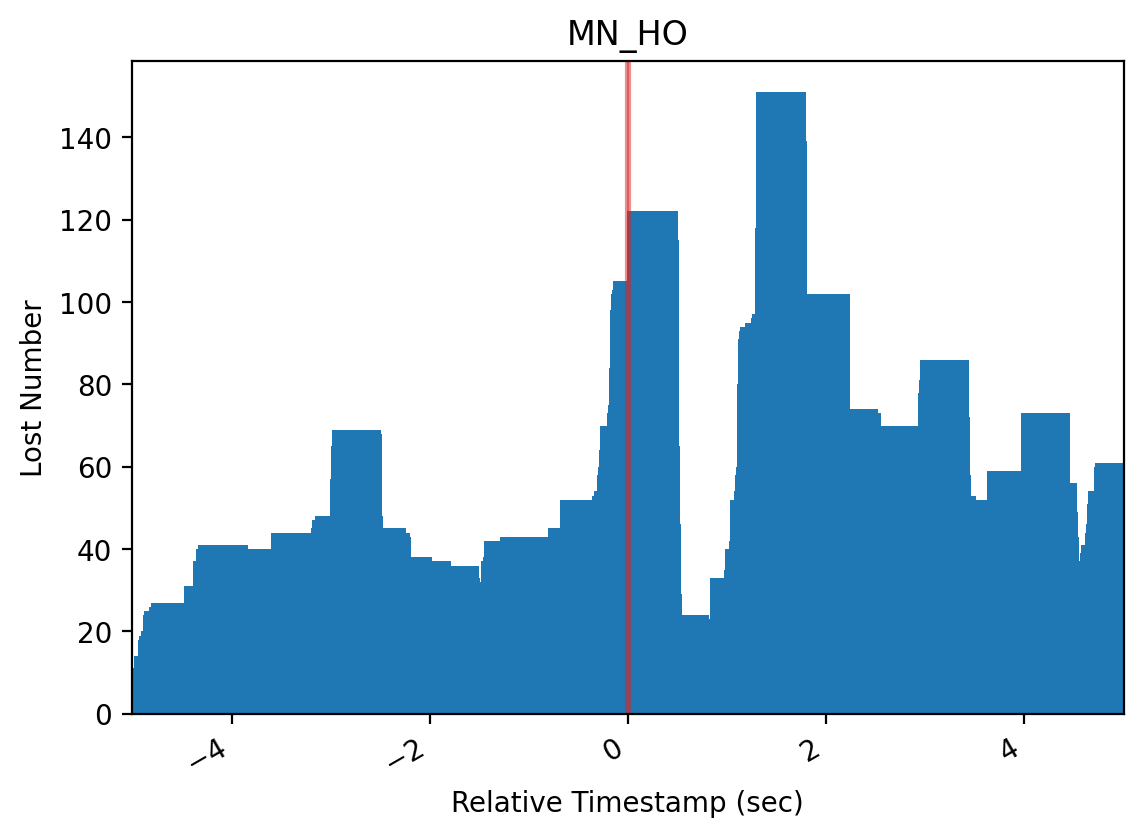

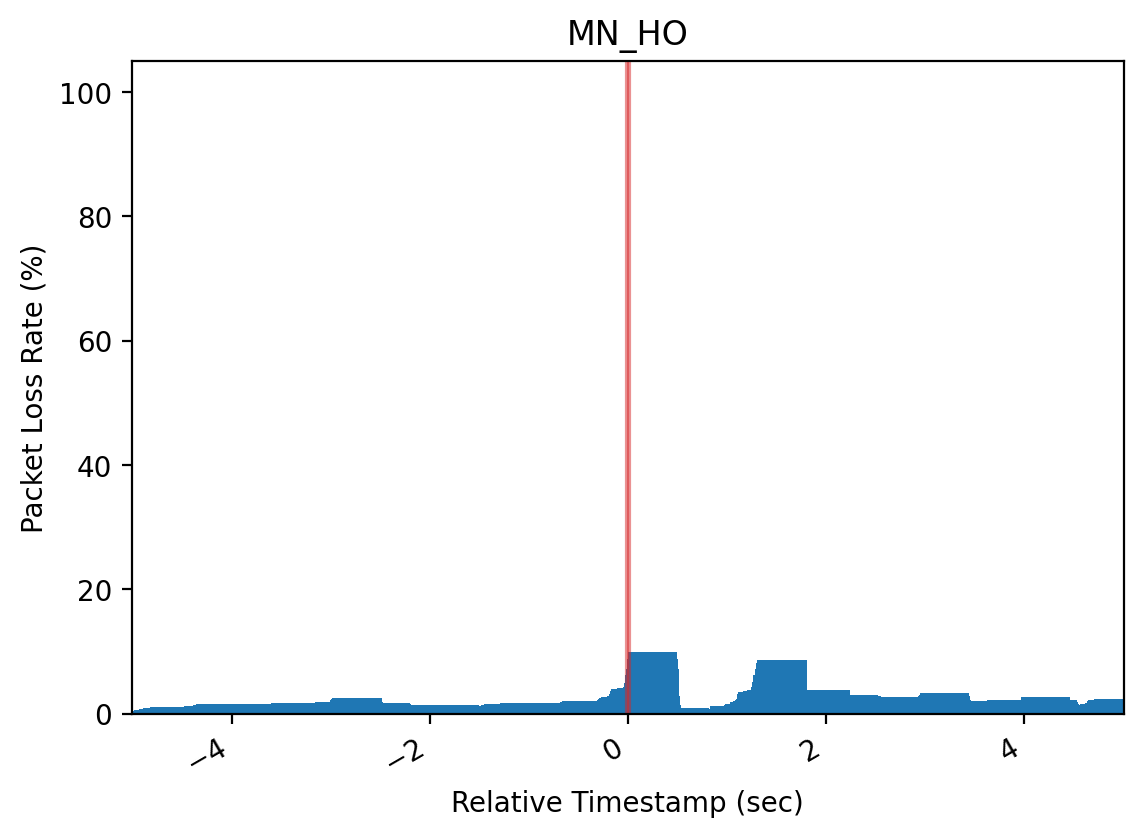

SN_HO
Avg Duration: 0.01453149 seconds
HO Count: 532


,cat_id,tx_count,lost,PLR
0,-5.01,547.0,5,0.914077
1,-5.00,2531.0,18,0.711181
2,-4.99,2441.0,20,0.819336
3,-4.98,2577.0,21,0.814901
4,-4.97,2565.0,19,0.740741
...,...,...,...,...
998,4.97,2665.0,50,1.876173
999,4.98,2663.0,50,1.877582
1000,4.99,2569.0,50,1.946283
1001,5.00,2690.0,51,1.895911


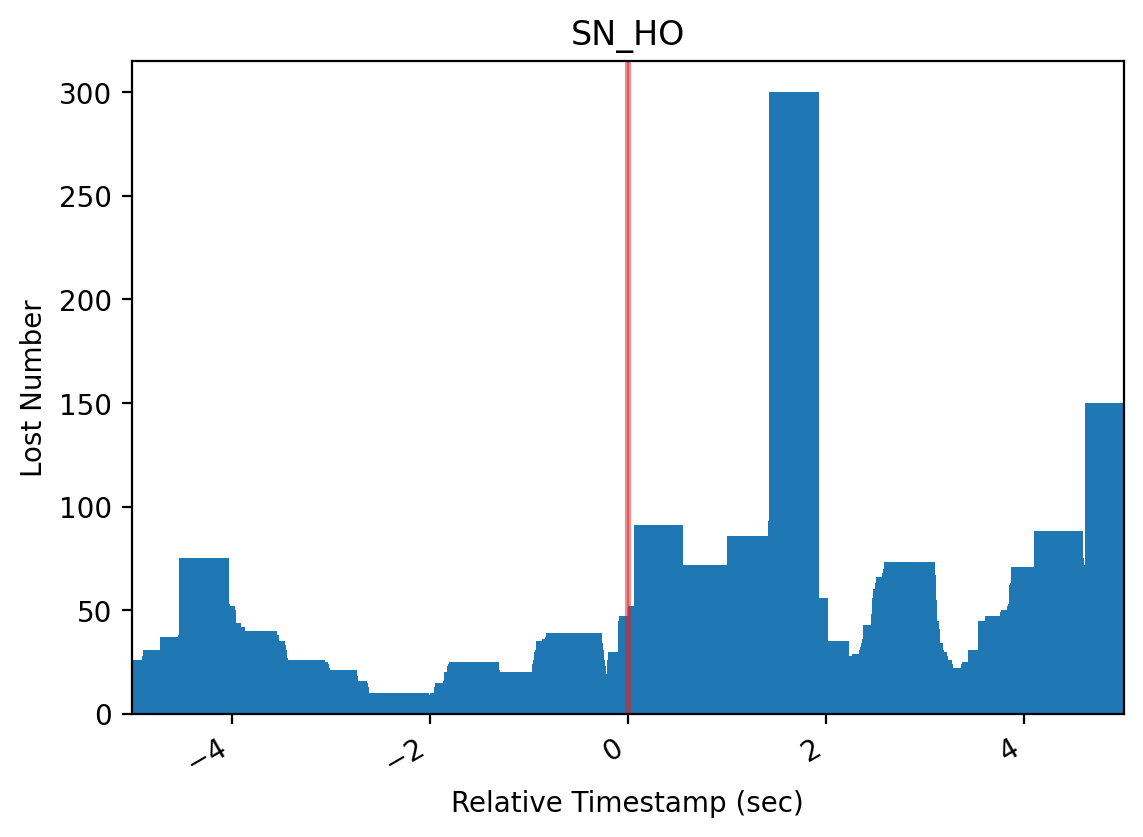

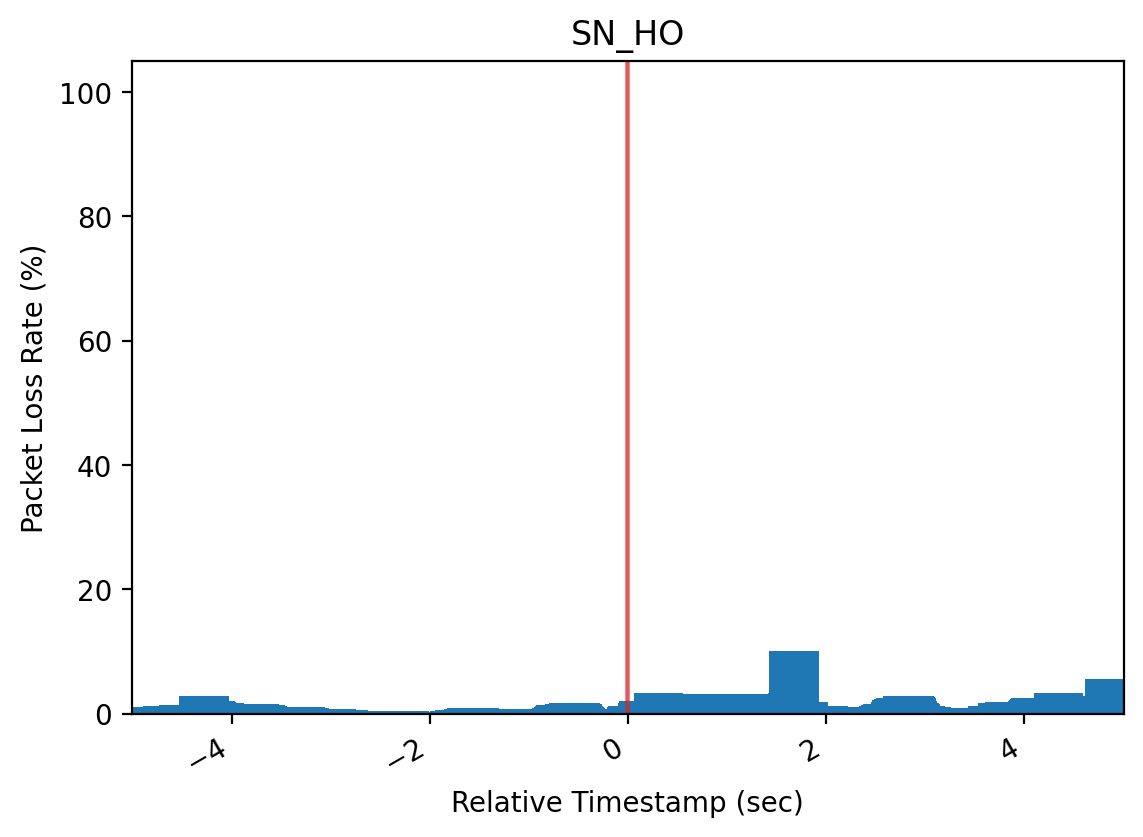

SN_Rel
Avg Duration: 0.026160002 seconds
HO Count: 5


,cat_id,tx_count,lost,PLR
0,-5.02,5.0,0,0.0
1,-5.01,17.0,0,0.0
2,-5.00,28.0,0,0.0
3,-4.99,13.0,0,0.0
4,-4.98,31.0,0,0.0
...,...,...,...,...
1000,4.98,16.0,0,0.0
1001,4.99,19.0,0,0.0
1002,5.00,23.0,0,0.0
1003,5.01,11.0,0,0.0


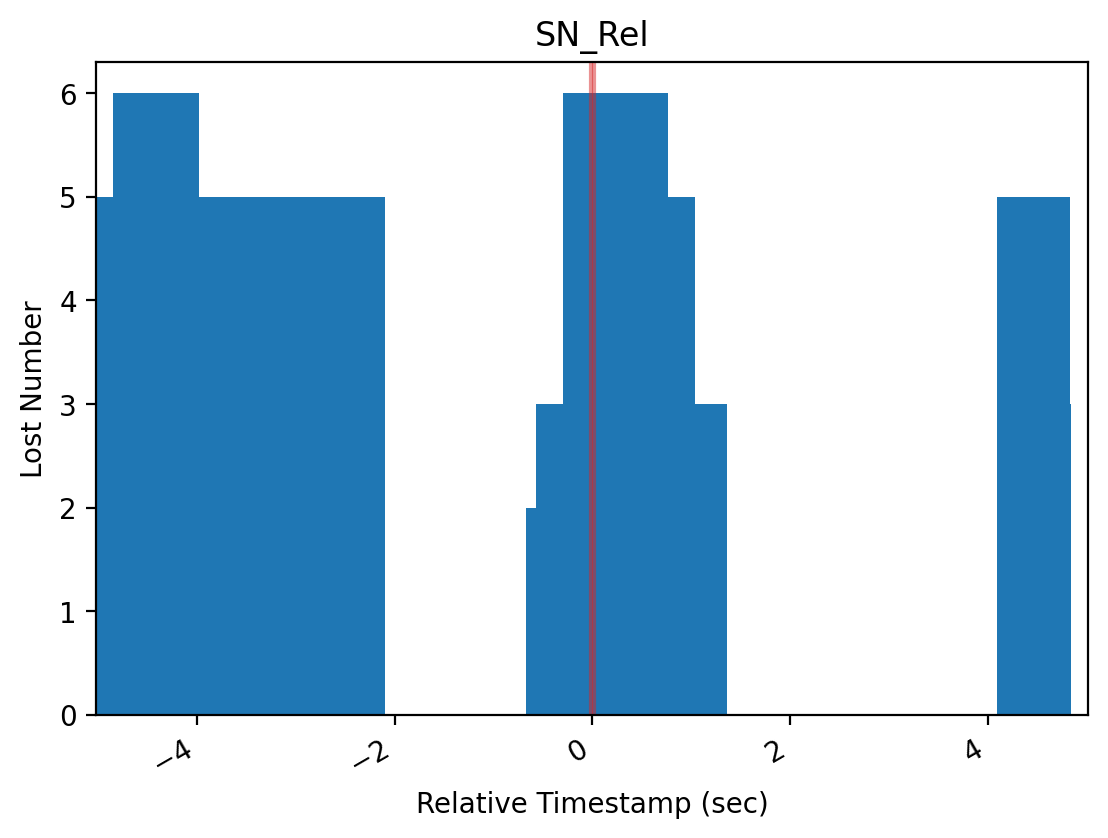

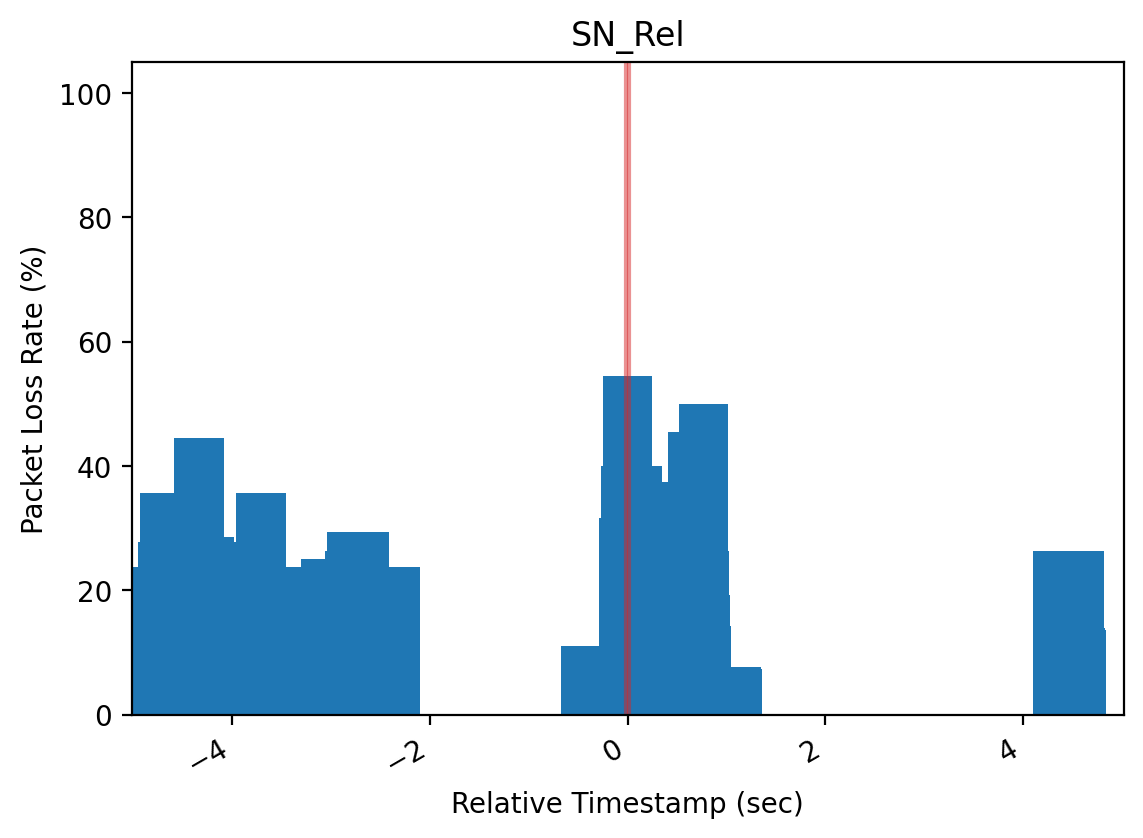

SN_Setup
Avg Duration: 0.027297968 seconds
HO Count: 175


,cat_id,tx_count,lost,PLR
0,-5.02,195.0,4,2.051282
1,-5.01,434.0,9,2.073733
2,-5.00,723.0,19,2.627939
3,-4.99,672.0,21,3.125
4,-4.98,693.0,19,2.741703
...,...,...,...,...
1000,4.98,735.0,57,7.755102
1001,4.99,745.0,43,5.771812
1002,5.00,662.0,39,5.891239
1003,5.01,451.0,34,7.538803


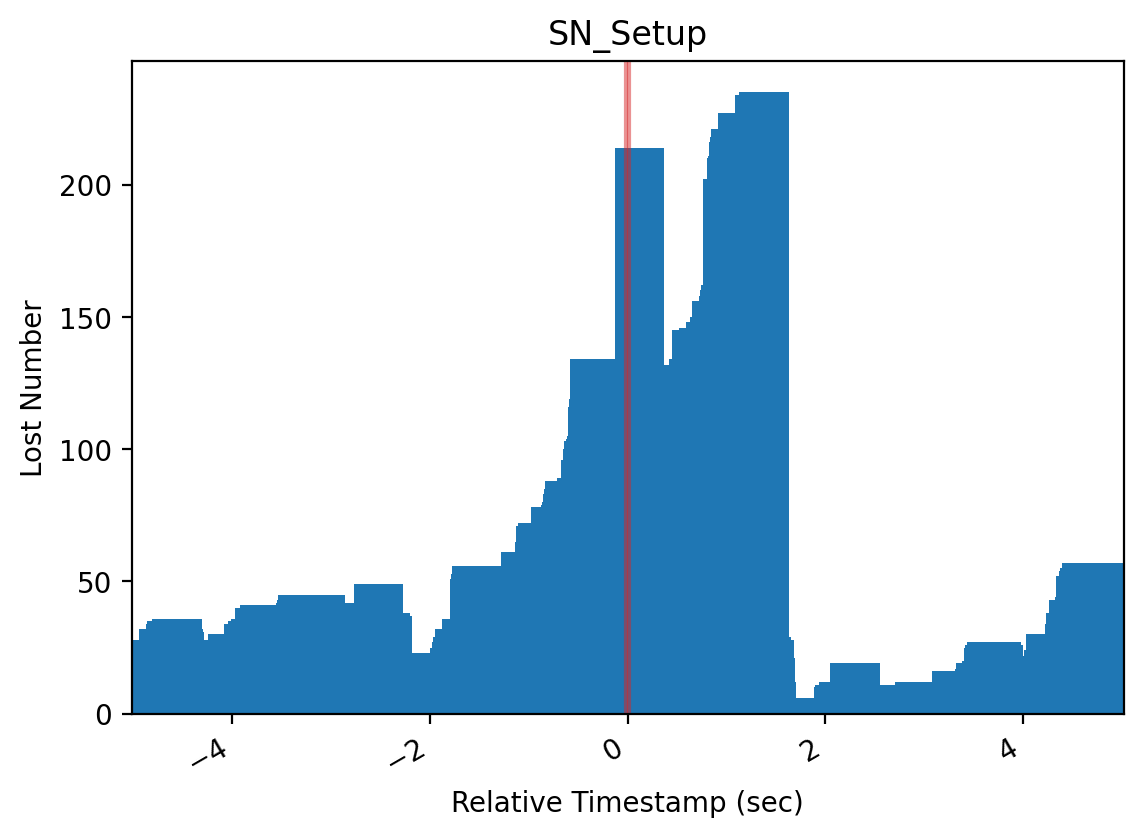

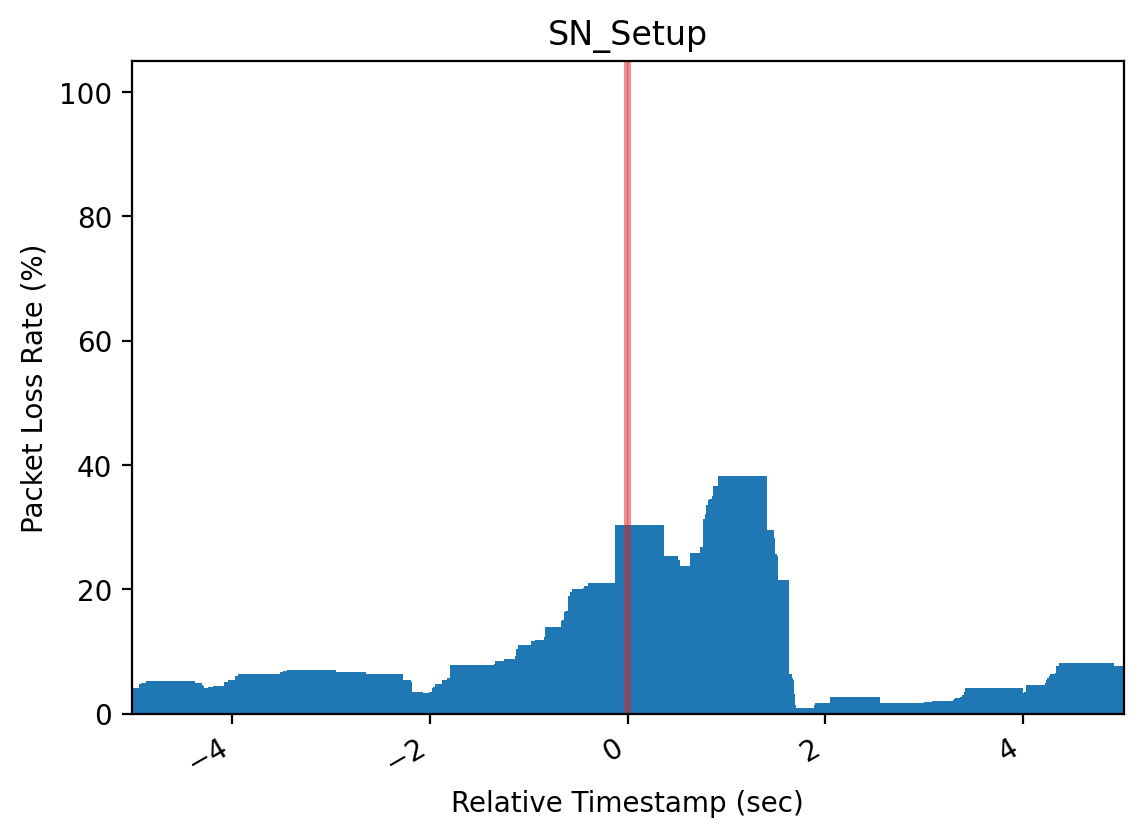

SCG_Failure_t310-Expiry (0)
Avg Duration: 0.0 seconds
HO Count: 2


,cat_id,tx_count,lost,PLR
0,-5.00,2,0,0.0
1,-4.99,13,0,0.0
2,-4.98,9,0,0.0
3,-4.97,8,0,0.0
4,-4.96,13,0,0.0
...,...,...,...,...
996,4.96,9,0,0.0
997,4.97,9,0,0.0
998,4.98,12,0,0.0
999,4.99,8,0,0.0


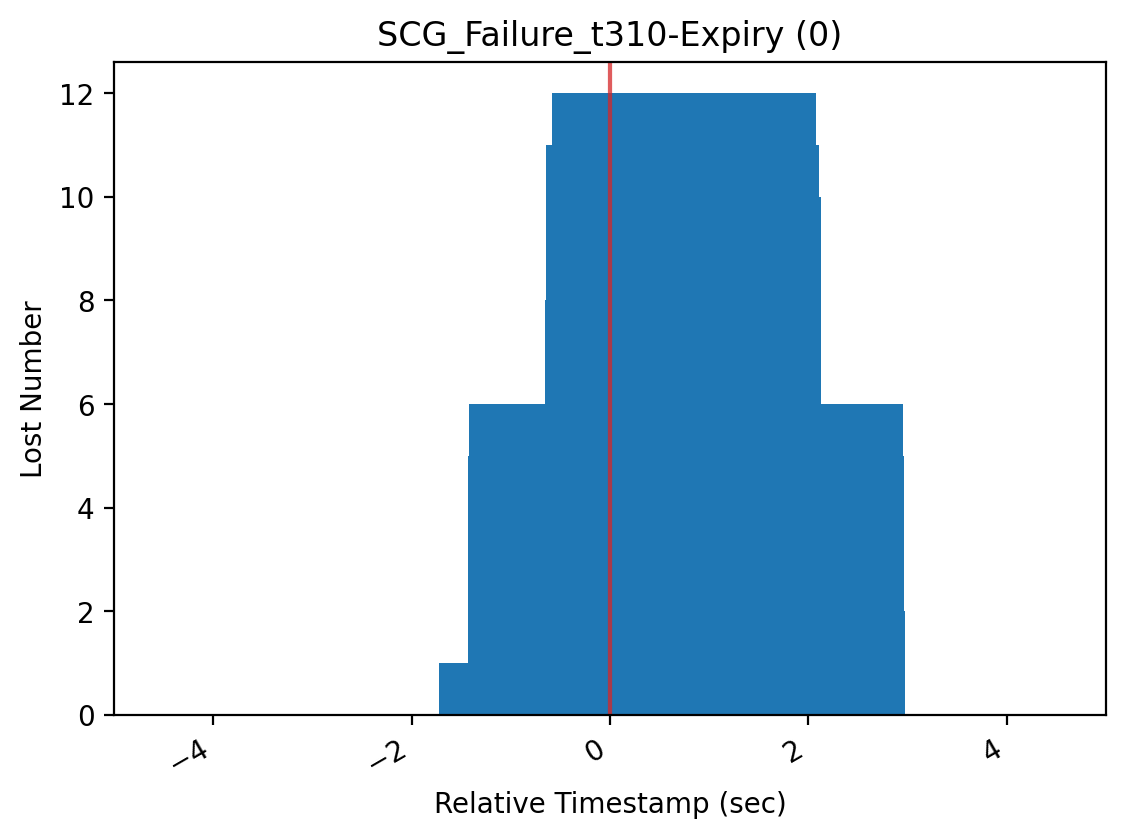

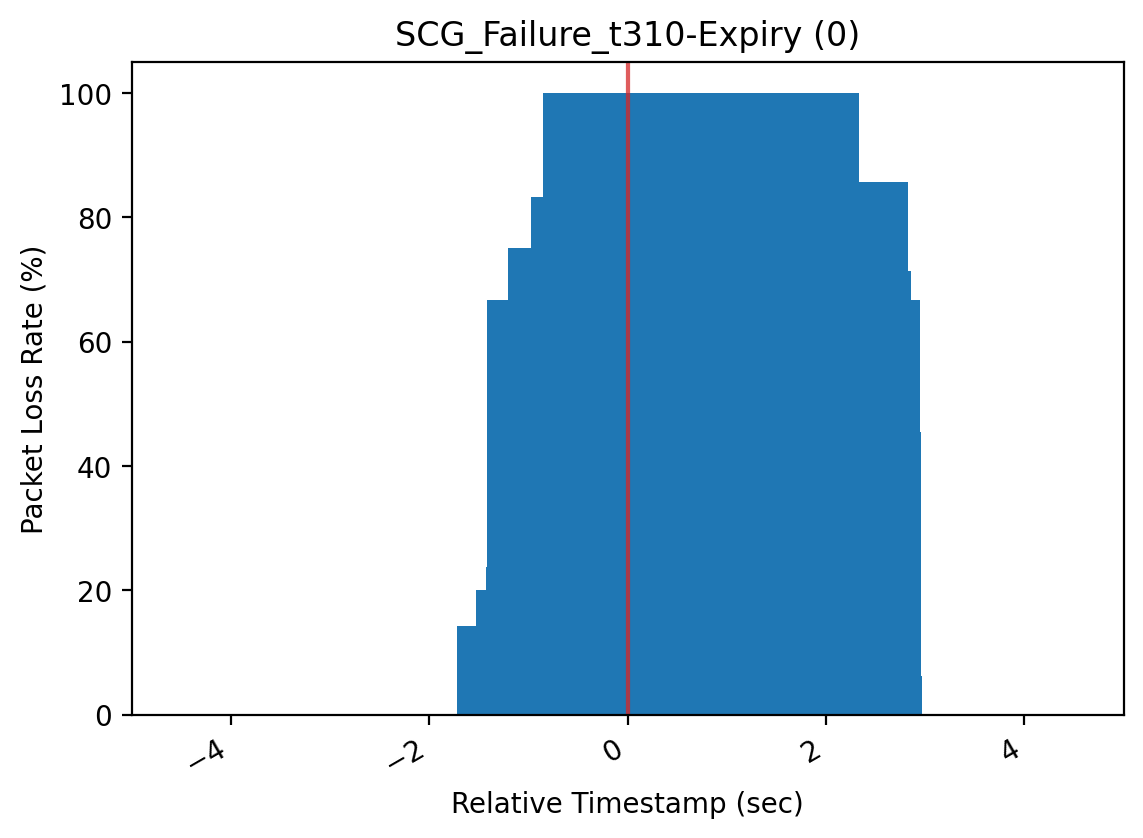

SCG_Failure_synchReconfigFailureSCG (3)
Avg Duration: 0.0 seconds
HO Count: 3


,cat_id,tx_count,lost,PLR
0,-5.00,7,0,0.0
1,-4.99,12,0,0.0
2,-4.98,20,0,0.0
3,-4.97,13,0,0.0
4,-4.96,13,0,0.0
...,...,...,...,...
996,4.96,10,0,0.0
997,4.97,7,0,0.0
998,4.98,13,0,0.0
999,4.99,11,0,0.0


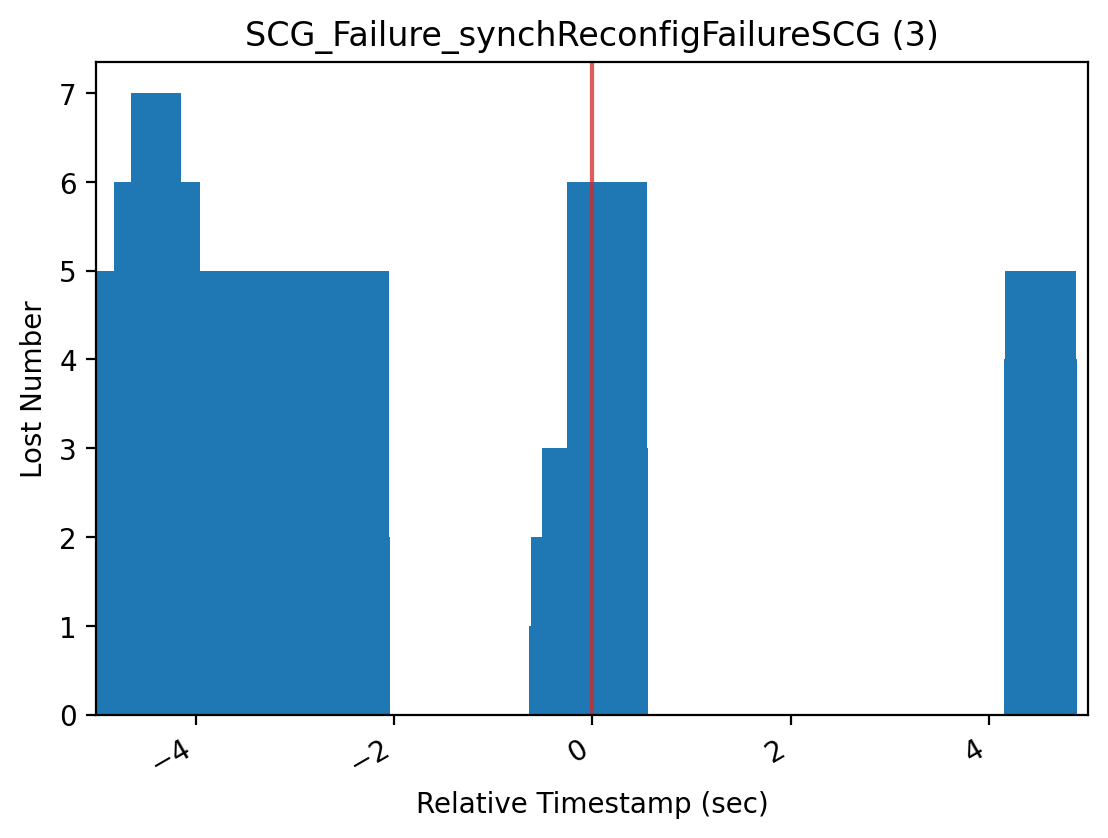

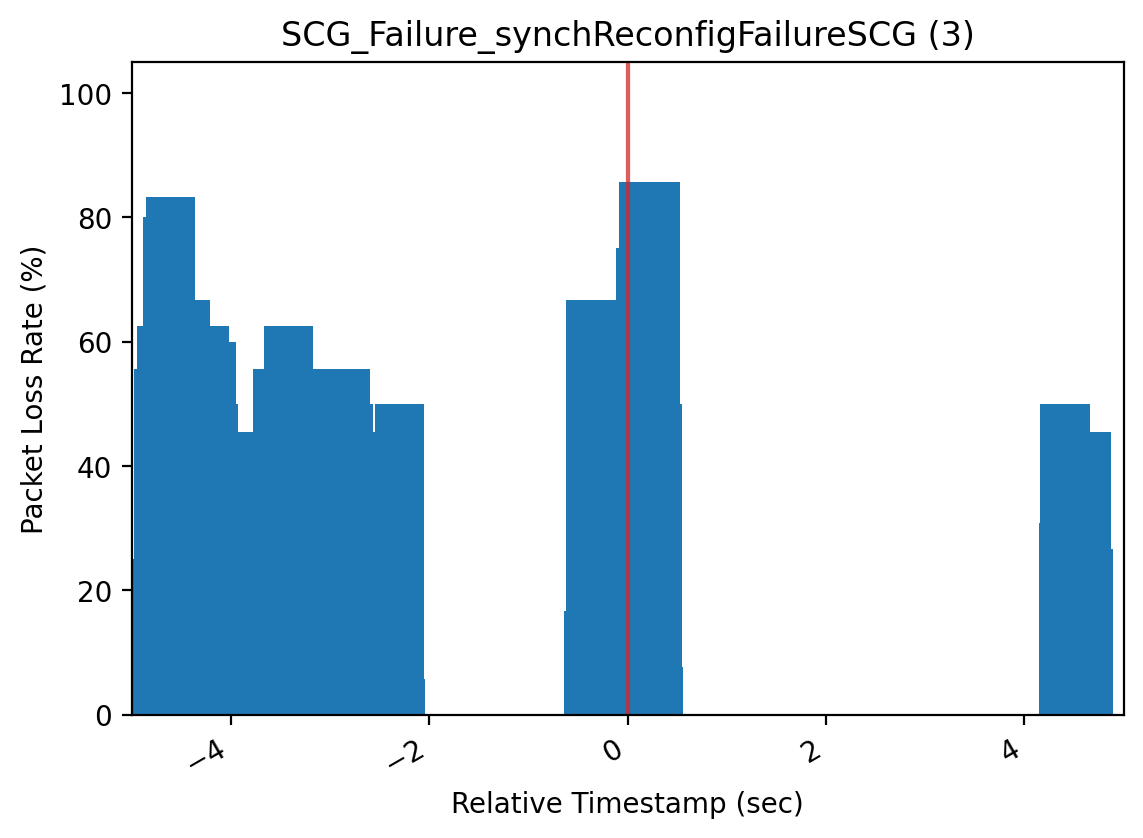

MCG_Failure_handoverFailure (1)
Avg Duration: 0.089919 seconds
HO Count: 6


,cat_id,tx_count,lost,PLR
0,-5.05,6.0,0,0.0
1,-5.04,31.0,0,0.0
2,-5.03,18.0,0,0.0
3,-5.02,35.0,0,0.0
4,-5.01,26.0,0,0.0
...,...,...,...,...
1006,5.01,28.0,0,0.0
1007,5.02,27.0,0,0.0
1008,5.03,33.0,0,0.0
1009,5.04,23.0,0,0.0


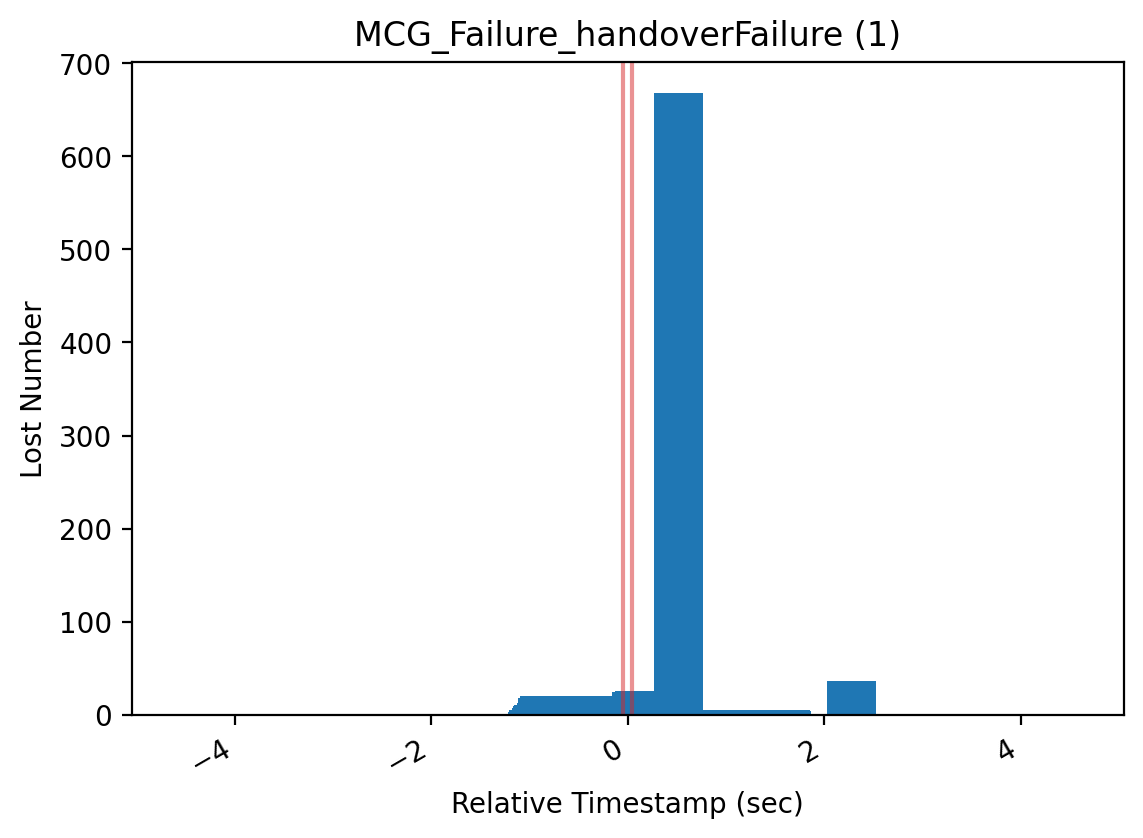

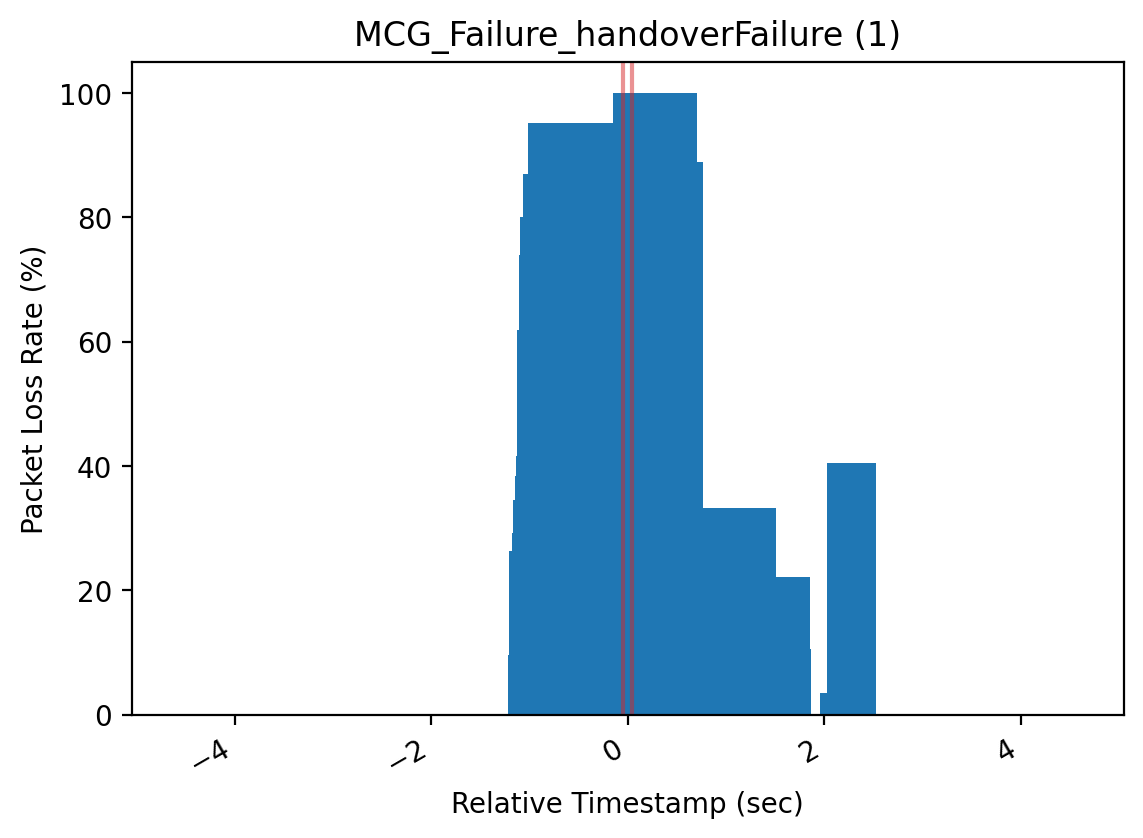

MCG_Failure_otherFailure (2)
Avg Duration: 0.07667868 seconds
HO Count: 77


,cat_id,tx_count,lost,PLR
0,-5.05,6.0,0,0.0
1,-5.04,160.0,0,0.0
2,-5.03,355.0,0,0.0
3,-5.02,380.0,0,0.0
4,-5.01,379.0,0,0.0
...,...,...,...,...
1006,5.01,366.0,15,4.098361
1007,5.02,381.0,14,3.674541
1008,5.03,326.0,15,4.601227
1009,5.04,115.0,5,4.347826


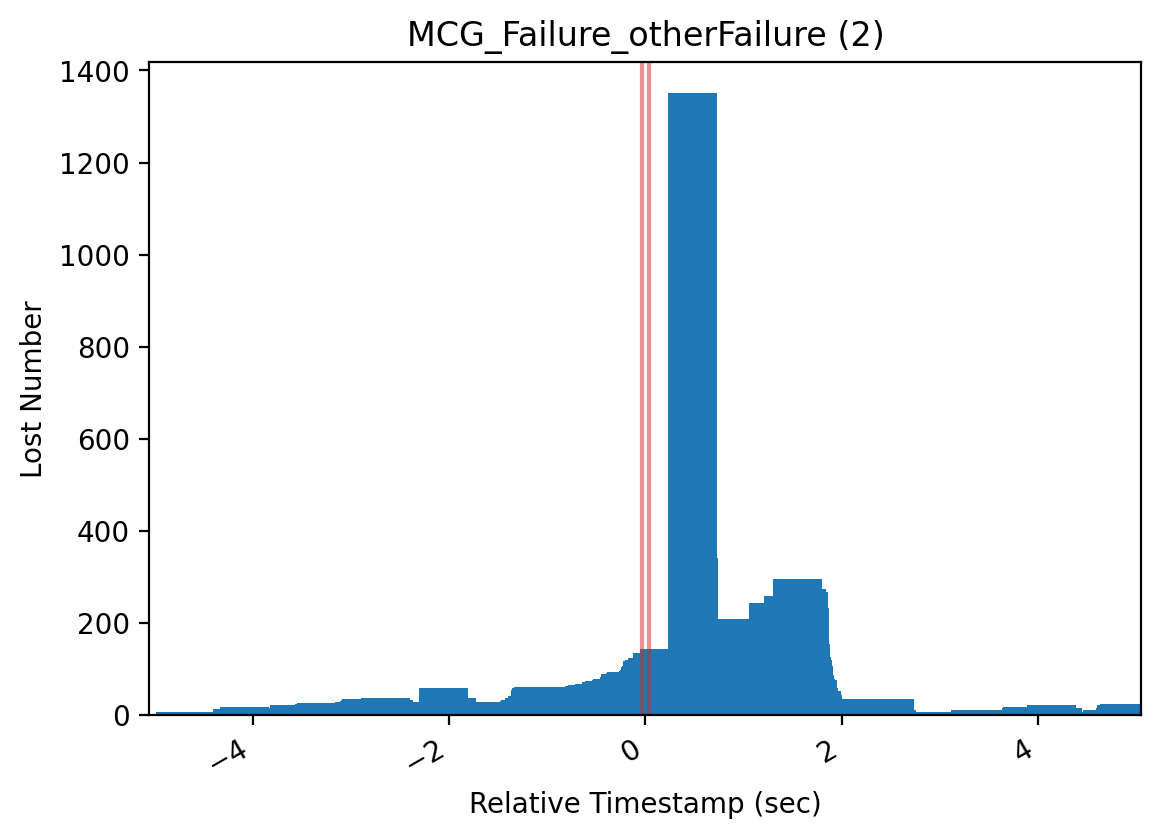

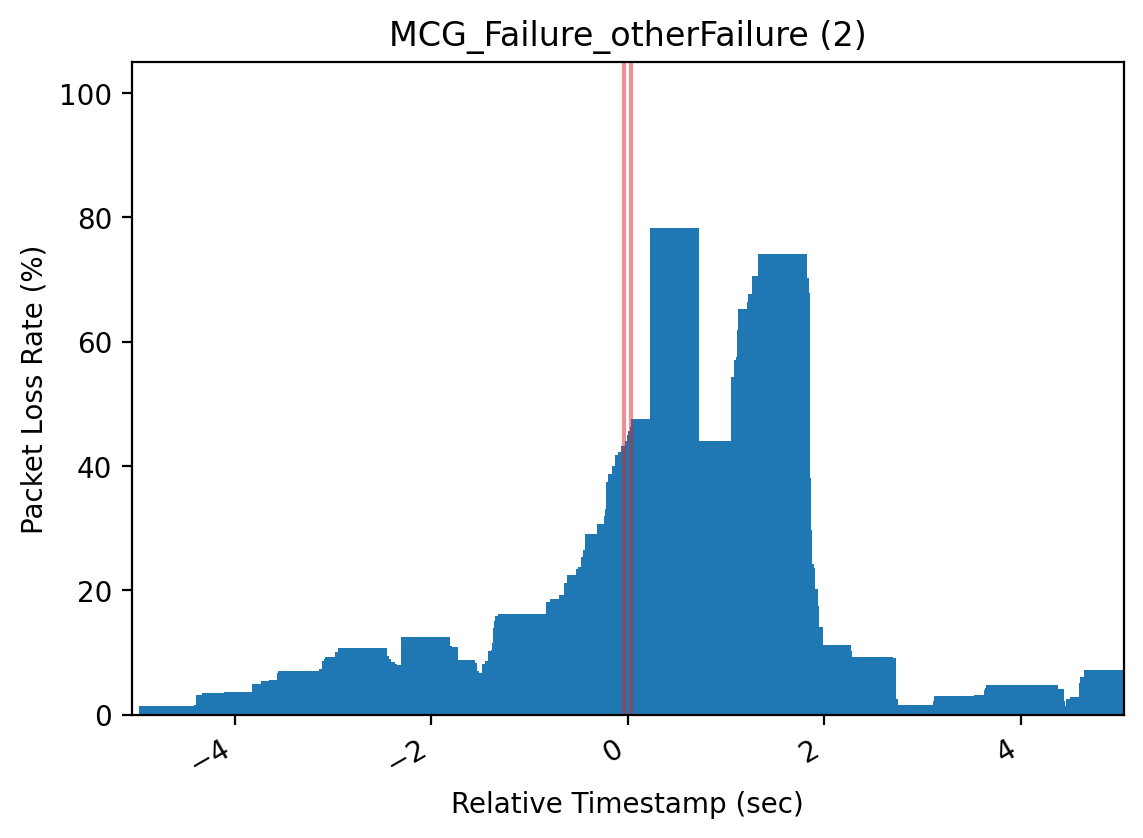

NAS_Recovery_otherFailure (2)
Avg Duration: 0.434173 seconds
HO Count: 1


,cat_id,tx_count,lost,PLR
0,-5.22,4,0,0.0
1,-5.21,2,0,0.0
2,-5.20,7,0,0.0
3,-5.19,6,0,0.0
4,-5.18,3,0,0.0
...,...,...,...,...
1013,5.18,4,0,0.0
1014,5.19,6,0,0.0
1015,5.20,6,0,0.0
1016,5.21,3,0,0.0


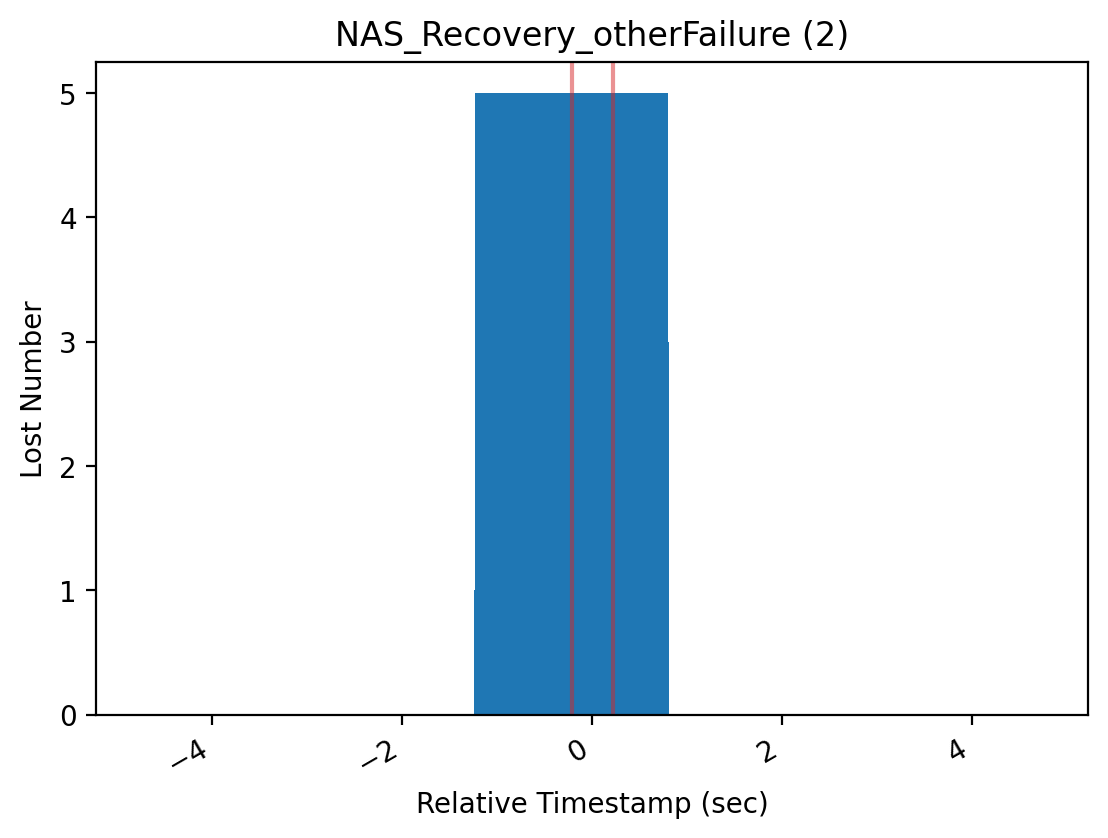

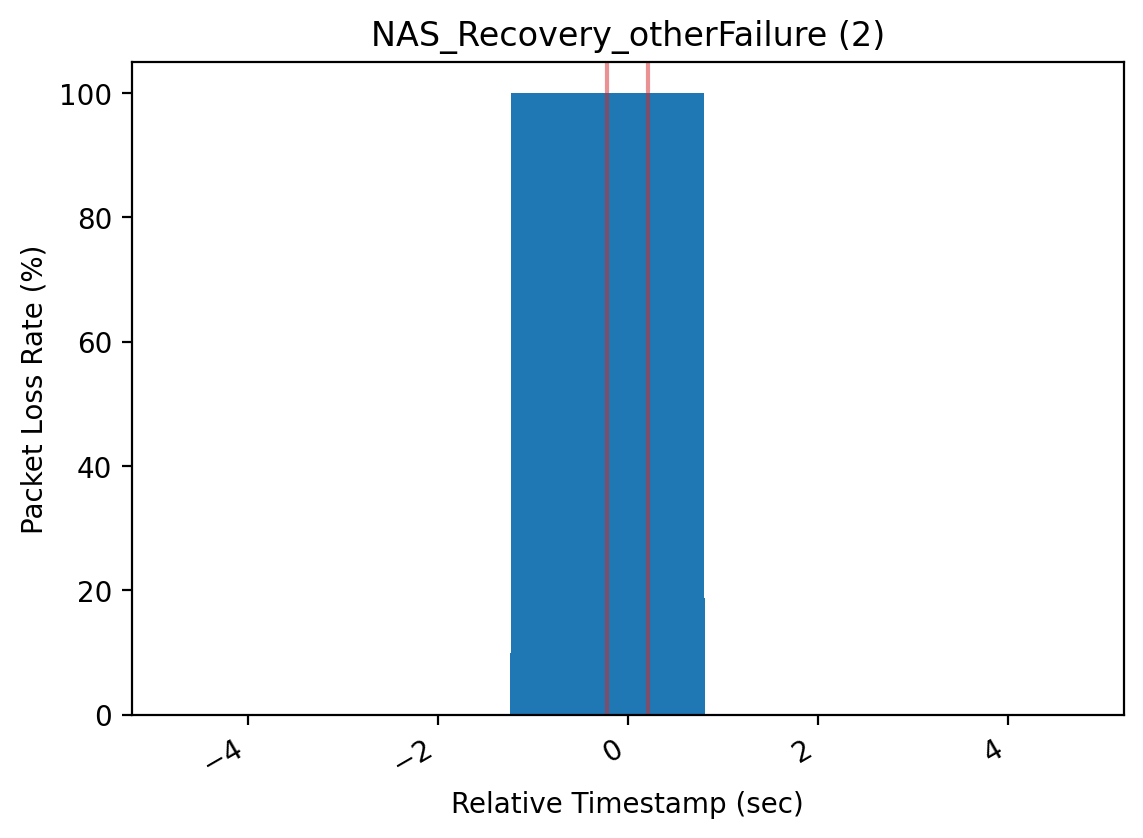

In [309]:
for tag in sorter:
    if len(D[tag]['intrs']) == 0:
        continue
    print('===================================')
    print(tag)
    table, intr = merge_profile(D[tag]['tables'], D[tag]['intrs'])
    print('Avg Duration:', intr, 'seconds')
    print('HO Count:', sum(D[tag]['count']))
    display(table)
    plot_profile(table, intr=intr, title=tag, mode='lost')
    plot_profile(table, intr=intr, title=tag, mode='plr')